In [ ]:
!pip install torch_geometric
!pip install biopython
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests
import networkx as nx
from scipy.spatial.distance import euclidean
from Bio.PDB import PDBParser, PDBList
from torch_geometric.nn import GCNConv, GraphNorm, global_mean_pool

from google.colab import drive
drive.mount('/content/drive')

from torch.utils.data import Dataset




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extract PDB file from uniprot id (wild-type)

def fetch_alphafold_pdb(uniprot_id, save_dir="wt_pdbs"):
    os.makedirs(save_dir, exist_ok=True)
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
    save_path = os.path.join(save_dir, f"{uniprot_id}.pdb")
    if not os.path.exists(save_path):
        r = requests.get(url)
        if r.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(r.content)
        else:
            raise ValueError(f"Could not fetch AlphaFold PDB for {uniprot_id}")
    return save_path

In [ ]:
# For the mutations becuase the unique PDBs used in the database correspond to the mutant protein

def fetch_pdb_on_demand(pdb_id, save_dir="pdbs"):
    pdbl = PDBList()
    pdb_id = pdb_id.lower()
    os.makedirs(save_dir, exist_ok=True)
    filepath = pdbl.retrieve_pdb_file(pdb_id, pdir=save_dir, file_format='pdb')
    actual_pdb_path = os.path.join(save_dir, f"{pdb_id}.pdb")
    if not os.path.exists(actual_pdb_path):
        os.rename(filepath, actual_pdb_path)
    return actual_pdb_path

In [ ]:
# Use the PDB to extract coordinates of residues (structural info)

def extract_residue_coords(pdb_file, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    model = structure[0]
    coords = {}
    for residue in model[chain_id]:
        if 'CA' in residue:
            res_id = residue.get_id()[1]
            coords[res_id] = residue['CA'].get_coord()
    return coords

In [ ]:
# build graph structure graph where nodes = residues, edges = distance (angstroms)

def build_protein_graph(coords, distance_threshold=8.0):
    G = nx.Graph()
    residue_ids = list(coords.keys())
    for res_id in residue_ids:
        G.add_node(res_id, pos=coords[res_id])
    for i, id1 in enumerate(residue_ids):
        for id2 in residue_ids[i+1:]:
            dist = euclidean(coords[id1], coords[id2])
            if dist <= distance_threshold:
                G.add_edge(id1, id2, distance=dist)
    return G

    # 8.0 angstrom threshold back up by literature: https://pmc.ncbi.nlm.nih.gov/articles/PMC3549380/

In [ ]:
# Construct the graph from predefined structure and populate with PDB extracted residue coordinates

def construct_graph_from_pdb(pdb_file, chain_id, distance_threshold=8.0):
    coords = extract_residue_coords(pdb_file, chain_id)
    return build_protein_graph(coords, distance_threshold)

In [ ]:
# One hot encode the protein based on the 20 amino acids

def one_hot_encode_aa(aa):
    aa_list = list("ACDEFGHIKLMNPQRSTVWY")
    return [int(aa == x) for x in aa_list]

In [ ]:
# Enrich the nodes with relevant functional features (amino acid type one-hot, catalytic pocket, position, relative pos, etc)

def enrich_graph_with_features(graph, row, sequence_length, mutate=False):
    sequence = row['sequence']
    catalytic = row['is_in_catalytic_pocket']
    essential = row['is_essential']
    mutation_pos = int(row['position'])
    mutant_aa = row['mutation']
    pdb_positions = sorted(graph.nodes)
    offset = min(pdb_positions)

    for pos in graph.nodes:
        seq_index = pos - offset
        if 0 <= seq_index < len(sequence):
            aa = sequence[seq_index]
            if mutate and pos == mutation_pos:
                aa = mutant_aa
            graph.nodes[pos]['aa_type'] = one_hot_encode_aa(aa)
            graph.nodes[pos]['is_catalytic'] = int(catalytic)
            graph.nodes[pos]['is_essential'] = int(essential)
            graph.nodes[pos]['relative_pos'] = pos / sequence_length
    return graph

In [ ]:
# Convert the graph from nx to pytorch object for graph processing

def convert_nx_to_pyg(graph, ddG_value=0.0):
    features = []
    node_id_map = {}
    filtered_nodes = []
    for i, n in enumerate(graph.nodes):
        node_data = graph.nodes[n]
        if all(k in node_data for k in ['aa_type', 'is_catalytic', 'is_essential', 'relative_pos']):
            node_id_map[n] = len(filtered_nodes)
            filtered_nodes.append(n)
            feat = node_data['aa_type'] + [
                node_data['is_catalytic'],
                node_data['is_essential'],
                node_data['relative_pos']
            ]
            features.append(feat)
    if len(features) == 0:
        raise ValueError("No usable nodes with complete features.")
    edge_index, edge_attr = [], []
    for u, v, attrs in graph.edges(data=True):
        if u in node_id_map and v in node_id_map:
            edge_index.append([node_id_map[u], node_id_map[v]])
            edge_index.append([node_id_map[v], node_id_map[u]])
            edge_attr.append([attrs['distance']])
            edge_attr.append([attrs['distance']])
    if len(edge_index) == 0:
        raise ValueError("No valid edges in graph.")
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor([ddG_value], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [ ]:
# Define DeltaDDGDataset class which extracts PDB structure and saves it per entry

# Note for future: consider storing the PDB files as a folder on Dropbox (.tar) for efficiency and speed. Store all PDB structures in one place.


# Global cache (can optionally persist to disk later)
structure_cache = {}

class DeltaDDGDataset(Dataset):
    def __init__(self, df):
        self.samples = []

        for _, row in tqdm(df.iterrows(), total=len(df), desc="Building dataset"):
            try:
                pdb_id = str(row['pdb_id']).split('|')[0].lower()
                uniprot_id = row['uniprot_id']

                # Cache structure fetches
                if pdb_id in structure_cache:
                    pdb_mut = structure_cache[pdb_id]
                else:
                    pdb_mut = fetch_pdb_on_demand(pdb_id)
                    structure_cache[pdb_id] = pdb_mut

                if uniprot_id in structure_cache:
                    pdb_wt = structure_cache[uniprot_id]
                else:
                    pdb_wt = fetch_alphafold_pdb(uniprot_id)
                    structure_cache[uniprot_id] = pdb_wt

                # Graph construction
                G_mut = construct_graph_from_pdb(pdb_mut, row['chain'])
                G_mut = enrich_graph_with_features(G_mut, row, len(row['sequence']), mutate=True)
                data_mut = convert_nx_to_pyg(G_mut, row['ddG'])
                data_mut.batch = torch.zeros(data_mut.num_nodes, dtype=torch.long)

                G_wt = construct_graph_from_pdb(pdb_wt, 'A')
                G_wt = enrich_graph_with_features(G_wt, row, len(row['sequence']), mutate=False)
                data_wt = convert_nx_to_pyg(G_wt, row['ddG'])
                data_wt.batch = torch.zeros(data_wt.num_nodes, dtype=torch.long)

                ddG = torch.tensor(row['ddG'], dtype=torch.float)
                metadata = row.to_dict()

                self.samples.append((data_wt, data_mut, ddG, metadata))

            except Exception as e:
                print(f"Skipping row due to error: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # Always returns (data_wt, data_mut, ddG, metadata)

    def save(self, path):
        data = {
            'samples': self.samples,
        }
        torch.save(data, path)

    @classmethod
    def load(cls, path):
        data = torch.load(path, weights_only=False)
        obj = cls.__new__(cls)
        obj.samples = data['samples']
        return obj


# Load Data

In [ ]:
### Load the Data

df = pd.read_csv('/content/drive/MyDrive/707_Files_for_Colab/df_with_skipped_flag.csv')

# this processed df only has unique experiment_id
# has a column at the end with true for if the protein was skipped due to error with extracting structure

In [ ]:
# Filter df to only keep the relevant columns

columns_to_keep = [
        'experiment_id', 'protein_name', 'uniprot_id', 'pdb_id', 'chain',
        'position', 'wild_type', 'mutation', 'ddG', 'sequence',
        'is_in_catalytic_pocket', 'is_essential'
]
df = df[columns_to_keep].dropna().drop_duplicates(subset=['experiment_id'])

In [ ]:
# Clear cache in order to make fetching PDB more efficient

structure_cache.clear()


# Testing the New DeltaDDGDataset Class (saving, loading, metadata as callable dictionary and not separate)

Objective: only test with 20 proteins and make sure that the relevant data is saved into the new DeltaDDGDataset class

In [ ]:
# Step 1: Select first 20 unique proteins
df_test_ahhh = df.drop_duplicates(subset='uniprot_id').head(20).reset_index(drop=True)

# Step 2: Build the dataset
test_dataset = DeltaDDGDataset(df_test_ahhh)

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


In [ ]:
# Step 3: Save to file
save_path = "/content/drive/MyDrive/delta_ddg_test_dataset_ahhh.pkl"
test_dataset.save(save_path)


In [ ]:
loaded_dataset = DeltaDDGDataset.load(save_path)

In [ ]:
train_loader = DataLoader(loaded_dataset, batch_size=4, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
next(iter(train_loader))

[DataBatch(x=[1500, 23], edge_index=[2, 13158], edge_attr=[13158, 1], y=[4], batch=[1500], ptr=[5]),
 DataBatch(x=[333, 23], edge_index=[2, 2988], edge_attr=[2988, 1], y=[4], batch=[333], ptr=[5]),
 tensor([0.1000, 0.6000, 1.5000, 1.6000]),
 {'experiment_id': ['VB02836', 'VB04491', 'VB03807', 'PT013341'],
  'protein_name': ['Polyubiquitin',
   'Tyrosine-protein kinase Fyn',
   'Dihydrolipoyllysine-residue acetyltransferase component of pyruvate dehydrogenase complex',
   'Myoglobin'],
  'uniprot_id': ['P0CG63', 'P06241', 'P11961', 'P02185'],
  'pdb_id': ['1OTR', '1SHF|1SHF|1SHF|1SHF', '1W4E|1W3D', '1BVC'],
  'chain': ['B', 'A', 'A', 'A'],
  'position': tensor([ 11, 120, 135, 150]),
  'wild_type': ['K', 'W', 'V', 'L'],
  'mutation': ['A', 'F', 'A', 'A'],
  'ddG': tensor([0.1000, 0.6000, 1.5000, 1.6000]),
  'sequence': ['MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEV

In [ ]:
loaded_dataset.__getitem__(0)

(Data(x=[155, 23], edge_index=[2, 1500], edge_attr=[1500, 1], y=[1], batch=[155]),
 Data(x=[129, 23], edge_index=[2, 1314], edge_attr=[1314, 1], y=[1], batch=[129]),
 tensor(-0.2000),
 {'experiment_id': 'VB02884',
  'protein_name': 'Fibroblast growth factor 1',
  'uniprot_id': 'P05230',
  'pdb_id': '2AFG|1RG8',
  'chain': 'A',
  'position': 108,
  'wild_type': 'H',
  'mutation': 'N',
  'ddG': -0.2,
  'sequence': 'MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTVDGTRDRSDQHIQLQLSAESVGEVYIKSTETGQYLAMDTDGLLYGSQTPNEECLFLERLEENHYNTYISKKHAEKNWFVGLKKNGSCKRGPRTHYGQKAILFLPLPVSSD',
  'is_in_catalytic_pocket': False,
  'is_essential': False})

# Pre-processing with Updated DeltaDDGDataset Class

In [ ]:
# Extract PDB, Build Graph, Split into Train and Val datasets (type: DeltaDDGDataset Class)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = DeltaDDGDataset(df_train)
val_dataset = DeltaDDGDataset(df_val)

Building dataset:   0%|          | 0/9672 [00:00<?, ?it/s]

Structure exists: 'pdbs/pdb1stn.ent' 


Building dataset:   0%|          | 1/9672 [00:00<40:21,  3.99it/s]

Building dataset:   0%|          | 2/9672 [00:01<2:14:34,  1.20it/s]

Structure exists: 'pdbs/pdb1vqb.ent' 


Building dataset:   0%|          | 3/9672 [00:01<1:32:14,  1.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   0%|          | 4/9672 [00:02<1:14:59,  2.15it/s]

Building dataset:   0%|          | 5/9672 [00:02<1:15:33,  2.13it/s]

Building dataset:   0%|          | 7/9672 [00:03<57:09,  2.82it/s]  

Structure exists: 'pdbs/pdb2lzm.ent' 
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   0%|          | 11/9672 [00:04<42:55,  3.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   0%|          | 12/9672 [00:04<37:28,  4.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   0%|          | 13/9672 [00:04<38:28,  4.18it/s]

Structure exists: 'pdbs/pdb1csp.ent' 


Building dataset:   0%|          | 14/9672 [00:05<50:01,  3.22it/s]

Structure exists: 'pdbs/pdb1wq5.ent' 


Building dataset:   0%|          | 15/9672 [00:05<58:09,  2.77it/s]

Building dataset:   0%|          | 17/9672 [00:06<42:39,  3.77it/s]

Skipping row due to error: 'A'
Structure exists: 'pdbs/pdb1lz1.ent' 


Building dataset:   0%|          | 18/9672 [00:06<47:02,  3.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:   0%|          | 19/9672 [00:06<44:59,  3.58it/s]

Structure exists: 'pdbs/pdb1amq.ent' 


Building dataset:   0%|          | 20/9672 [00:07<1:20:14,  2.00it/s]

Building dataset:   0%|          | 22/9672 [00:09<2:00:38,  1.33it/s]

Building dataset:   0%|          | 23/9672 [00:10<1:50:18,  1.46it/s]

Structure exists: 'pdbs/pdb1pga.ent' 


Building dataset:   0%|          | 24/9672 [00:11<2:08:46,  1.25it/s]

Building dataset:   0%|          | 27/9672 [00:13<2:08:45,  1.25it/s]

Building dataset:   0%|          | 31/9672 [00:48<18:59:11,  7.09s/it]

Building dataset:   0%|          | 32/9672 [00:50<14:50:31,  5.54s/it]

Building dataset:   0%|          | 34/9672 [00:51<7:55:11,  2.96s/it] 

Structure exists: 'pdbs/pdb2aky.ent' 


Building dataset:   0%|          | 44/9672 [00:56<1:13:01,  2.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   0%|          | 46/9672 [00:57<54:53,  2.92it/s]  

Building dataset:   0%|          | 48/9672 [00:57<54:17,  2.95it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 49/9672 [00:58<49:50,  3.22it/s]

Building dataset:   1%|          | 52/9672 [00:59<1:05:26,  2.45it/s]

Building dataset:   1%|          | 53/9672 [01:00<1:17:46,  2.06it/s]

Building dataset:   1%|          | 54/9672 [01:24<20:31:15,  7.68s/it]

Building dataset:   1%|          | 55/9672 [01:25<15:00:03,  5.62s/it]

Building dataset:   1%|          | 57/9672 [01:26<7:44:06,  2.90s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 59/9672 [01:26<4:31:34,  1.70s/it]

Building dataset:   1%|          | 64/9672 [01:28<1:30:10,  1.78it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 66/9672 [01:29<1:19:50,  2.01it/s]

Building dataset:   1%|          | 69/9672 [01:29<50:46,  3.15it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 71/9672 [01:30<38:55,  4.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 75/9672 [01:55<14:10:17,  5.32s/it]

Building dataset:   1%|          | 76/9672 [01:55<10:25:43,  3.91s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:   1%|          | 78/9672 [01:56<5:35:13,  2.10s/it]

Structure exists: 'pdbs/pdb1rgg.ent' 
Structure exists: 'pdbs/pdb1bvc.ent' 


Building dataset:   1%|          | 82/9672 [01:57<1:48:13,  1.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   1%|          | 83/9672 [01:58<2:32:31,  1.05it/s]

Building dataset:   1%|          | 86/9672 [01:59<1:32:11,  1.73it/s]

Building dataset:   1%|          | 87/9672 [02:00<1:29:14,  1.79it/s]

Building dataset:   1%|          | 88/9672 [02:01<2:16:30,  1.17it/s]

Building dataset:   1%|          | 91/9672 [02:03<1:42:39,  1.56it/s]

Structure exists: 'pdbs/pdb1tup.ent' 


Building dataset:   1%|          | 92/9672 [02:04<2:04:09,  1.29it/s]

Building dataset:   1%|          | 94/9672 [02:07<2:47:27,  1.05s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 97/9672 [02:08<1:23:09,  1.92it/s]

Skipping row due to error: 'A'


Building dataset:   1%|          | 98/9672 [02:08<1:12:54,  2.19it/s]

Building dataset:   1%|          | 101/9672 [02:09<49:20,  3.23it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   1%|          | 103/9672 [02:10<47:05,  3.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 105/9672 [02:10<51:45,  3.08it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|          | 106/9672 [02:11<1:07:47,  2.35it/s]

Building dataset:   1%|          | 109/9672 [02:13<1:09:20,  2.30it/s]

Building dataset:   1%|          | 112/9672 [02:15<1:32:16,  1.73it/s]

Building dataset:   1%|          | 114/9672 [02:17<1:49:46,  1.45it/s]

Building dataset:   1%|          | 115/9672 [02:17<1:35:49,  1.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   1%|          | 116/9672 [02:18<1:19:14,  2.01it/s]

Building dataset:   1%|          | 117/9672 [02:21<3:19:48,  1.25s/it]

Building dataset:   1%|          | 119/9672 [02:21<2:01:52,  1.31it/s]

Building dataset:   1%|▏         | 124/9672 [02:23<54:51,  2.90it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   1%|▏         | 129/9672 [02:25<41:30,  3.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|▏         | 131/9672 [02:25<50:25,  3.15it/s]

Building dataset:   1%|▏         | 134/9672 [02:27<56:59,  2.79it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|▏         | 137/9672 [02:27<38:25,  4.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|▏         | 139/9672 [02:28<37:02,  4.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|▏         | 142/9672 [02:30<55:51,  2.84it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   2%|▏         | 149/9672 [02:50<7:19:55,  2.77s/it]

Building dataset:   2%|▏         | 155/9672 [02:51<1:23:16,  1.90it/s]

Structure exists: 'pdbs/pdb2rn2.ent' 


Building dataset:   2%|▏         | 157/9672 [02:52<1:07:43,  2.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:   2%|▏         | 161/9672 [02:53<43:50,  3.62it/s]

Building dataset:   2%|▏         | 162/9672 [02:54<1:30:37,  1.75it/s]

Building dataset:   2%|▏         | 164/9672 [02:55<1:17:55,  2.03it/s]

Structure exists: 'pdbs/pdb1shf.ent' 


Building dataset:   2%|▏         | 166/9672 [02:56<1:18:05,  2.03it/s]

Building dataset:   2%|▏         | 168/9672 [03:21<14:23:10,  5.45s/it]

Building dataset:   2%|▏         | 170/9672 [03:22<7:37:22,  2.89s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   2%|▏         | 175/9672 [03:42<8:35:10,  3.25s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   2%|▏         | 177/9672 [03:43<5:08:53,  1.95s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   2%|▏         | 184/9672 [03:47<1:10:51,  2.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:   2%|▏         | 193/9672 [03:50<38:20,  4.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   2%|▏         | 194/9672 [03:50<55:37,  2.84it/s]

Building dataset:   2%|▏         | 201/9672 [03:53<46:15,  3.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   2%|▏         | 206/9672 [03:54<34:58,  4.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   2%|▏         | 213/9672 [03:57<48:21,  3.26it/s]  

Building dataset:   2%|▏         | 215/9672 [03:58<57:54,  2.72it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   2%|▏         | 220/9672 [04:00<37:03,  4.25it/s]

Building dataset:   2%|▏         | 229/9672 [04:03<1:02:50,  2.50it/s]

Building dataset:   2%|▏         | 230/9672 [04:04<59:01,  2.67it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:   2%|▏         | 233/9672 [04:05<50:38,  3.11it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   2%|▏         | 234/9672 [04:05<47:08,  3.34it/s]

Building dataset:   3%|▎         | 242/9672 [04:08<52:07,  3.02it/s]  

Building dataset:   3%|▎         | 245/9672 [04:09<44:21,  3.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:   3%|▎         | 250/9672 [04:12<1:01:13,  2.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   3%|▎         | 255/9672 [04:14<56:26,  2.78it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 269/9672 [04:20<48:12,  3.25it/s]

Building dataset:   3%|▎         | 273/9672 [04:22<55:05,  2.84it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 276/9672 [04:23<50:22,  3.11it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 282/9672 [04:49<7:11:10,  2.76s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 286/9672 [04:50<2:21:33,  1.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 291/9672 [04:52<1:11:43,  2.18it/s]

Building dataset:   3%|▎         | 292/9672 [04:53<1:41:10,  1.55it/s]

Building dataset:   3%|▎         | 295/9672 [04:56<1:50:37,  1.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   3%|▎         | 298/9672 [04:57<1:04:51,  2.41it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 299/9672 [04:58<1:13:08,  2.14it/s]

Building dataset:   3%|▎         | 304/9672 [04:59<46:42,  3.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 310/9672 [05:04<1:06:50,  2.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 316/9672 [05:06<56:38,  2.75it/s]  

Building dataset:   3%|▎         | 329/9672 [05:37<1:58:16,  1.32it/s]

Building dataset:   3%|▎         | 330/9672 [05:38<2:44:39,  1.06s/it]

Building dataset:   3%|▎         | 333/9672 [05:40<1:49:04,  1.43it/s]

Building dataset:   3%|▎         | 338/9672 [05:42<41:26,  3.75it/s]  

Skipping row due to error: 'A'


Building dataset:   4%|▎         | 342/9672 [06:05<11:19:08,  4.37s/it]

Building dataset:   4%|▎         | 344/9672 [06:07<7:33:19,  2.92s/it]

Building dataset:   4%|▎         | 347/9672 [06:09<3:54:01,  1.51s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▎         | 349/9672 [06:10<2:28:35,  1.05it/s]

Building dataset:   4%|▎         | 351/9672 [06:10<1:45:20,  1.47it/s]

Structure exists: 'pdbs/pdb1otr.ent' 


Building dataset:   4%|▎         | 355/9672 [06:12<56:02,  2.77it/s]  

Building dataset:   4%|▍         | 366/9672 [06:15<39:58,  3.88it/s]

Building dataset:   4%|▍         | 368/9672 [06:18<1:49:02,  1.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▍         | 389/9672 [06:52<1:24:45,  1.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▍         | 399/9672 [06:59<1:38:46,  1.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   4%|▍         | 401/9672 [07:26<15:28:25,  6.01s/it]

Structure exists: 'pdbs/pdb1mjc.ent' 


Building dataset:   4%|▍         | 406/9672 [07:27<3:59:25,  1.55s/it]

Skipping row due to error: 'A'


Building dataset:   4%|▍         | 408/9672 [07:28<2:59:58,  1.17s/it]

Building dataset:   4%|▍         | 409/9672 [07:29<2:44:14,  1.06s/it]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:   4%|▍         | 420/9672 [07:34<1:00:04,  2.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▍         | 423/9672 [07:34<36:45,  4.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▍         | 424/9672 [07:35<55:47,  2.76it/s]

Building dataset:   4%|▍         | 427/9672 [07:36<41:02,  3.75it/s]

Building dataset:   4%|▍         | 429/9672 [07:37<51:55,  2.97it/s]  

Skipping row due to error: 'A'


Building dataset:   5%|▍         | 442/9672 [07:40<39:47,  3.87it/s]

Building dataset:   5%|▍         | 444/9672 [07:42<1:10:59,  2.17it/s]

Building dataset:   5%|▍         | 446/9672 [07:42<1:01:20,  2.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:   5%|▍         | 459/9672 [07:49<1:24:00,  1.83it/s]

Building dataset:   5%|▍         | 463/9672 [08:11<8:47:20,  3.44s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   5%|▍         | 469/9672 [08:36<6:13:56,  2.44s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   5%|▍         | 472/9672 [08:37<3:04:06,  1.20s/it]

Structure exists: 'pdbs/pdb1w4e.ent' 


Building dataset:   5%|▍         | 483/9672 [08:42<59:17,  2.58it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   5%|▌         | 487/9672 [08:45<1:56:41,  1.31it/s]

Skipping row due to error: 'A'


Building dataset:   5%|▌         | 495/9672 [08:48<54:00,  2.83it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   5%|▌         | 497/9672 [08:48<43:35,  3.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   5%|▌         | 516/9672 [09:22<1:50:39,  1.38it/s]

Skipping row due to error: 'A'


Building dataset:   6%|▌         | 535/9672 [09:51<6:03:14,  2.39s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   6%|▌         | 548/9672 [10:13<1:42:35,  1.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 549/9672 [10:14<1:41:27,  1.50it/s]

Skipping row due to error: 'A'


Building dataset:   6%|▌         | 553/9672 [10:15<1:12:07,  2.11it/s]

Skipping row due to error: 'A'


Building dataset:   6%|▌         | 557/9672 [10:16<38:50,  3.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 569/9672 [10:21<1:03:09,  2.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:   6%|▌         | 576/9672 [10:22<34:16,  4.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 578/9672 [10:23<34:34,  4.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 580/9672 [10:24<1:01:08,  2.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 583/9672 [10:25<54:11,  2.80it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 586/9672 [10:26<43:16,  3.50it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 591/9672 [10:27<44:49,  3.38it/s]

Building dataset:   6%|▌         | 593/9672 [10:40<6:57:47,  2.76s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 595/9672 [10:40<3:56:06,  1.56s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   6%|▌         | 599/9672 [10:41<1:44:17,  1.45it/s]

Skipping row due to error: 'A'


Building dataset:   6%|▌         | 602/9672 [10:42<59:06,  2.56it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:   6%|▌         | 604/9672 [10:42<41:06,  3.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▋         | 612/9672 [10:45<56:44,  2.66it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▋         | 614/9672 [10:46<43:01,  3.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   6%|▋         | 622/9672 [10:50<49:03,  3.07it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   7%|▋         | 632/9672 [10:54<51:20,  2.93it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   7%|▋         | 633/9672 [10:54<45:04,  3.34it/s]

Building dataset:   7%|▋         | 640/9672 [10:58<50:52,  2.96it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   7%|▋         | 644/9672 [10:59<51:12,  2.94it/s]

Building dataset:   7%|▋         | 649/9672 [11:02<48:22,  3.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   7%|▋         | 653/9672 [11:03<49:58,  3.01it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   7%|▋         | 654/9672 [11:04<53:58,  2.78it/s]

Skipping row due to error: 'A'


Building dataset:   7%|▋         | 662/9672 [11:07<1:02:50,  2.39it/s]

Building dataset:   7%|▋         | 671/9672 [11:10<44:32,  3.37it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   7%|▋         | 678/9672 [11:14<1:09:28,  2.16it/s]

Building dataset:   7%|▋         | 685/9672 [11:18<1:13:08,  2.05it/s]

Structure exists: 'pdbs/pdb2afg.ent' 


Building dataset:   8%|▊         | 726/9672 [11:55<1:32:27,  1.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 734/9672 [12:21<2:19:15,  1.07it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 736/9672 [12:47<13:18:55,  5.36s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 738/9672 [12:48<7:40:11,  3.09s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 739/9672 [12:48<5:38:16,  2.27s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 750/9672 [13:20<1:50:44,  1.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 752/9672 [13:21<1:23:59,  1.77it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:   8%|▊         | 763/9672 [13:24<47:13,  3.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 768/9672 [13:25<40:00,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 776/9672 [13:32<1:50:49,  1.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 777/9672 [13:32<1:50:19,  1.34it/s]

Skipping row due to error: 'A'


Building dataset:   8%|▊         | 780/9672 [13:55<10:43:54,  4.34s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 784/9672 [13:56<3:17:56,  1.34s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   8%|▊         | 794/9672 [14:00<46:02,  3.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 796/9672 [14:01<41:17,  3.58it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:   8%|▊         | 802/9672 [14:02<32:56,  4.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 812/9672 [14:07<51:59,  2.84it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 818/9672 [14:10<44:51,  3.29it/s]  

Skipping row due to error: 'A'


Building dataset:   9%|▊         | 824/9672 [14:12<42:30,  3.47it/s]

Building dataset:   9%|▊         | 826/9672 [14:13<55:24,  2.66it/s]

Skipping row due to error: 'A'


Building dataset:   9%|▊         | 833/9672 [14:15<43:34,  3.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   9%|▊         | 839/9672 [15:06<12:52:49,  5.25s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   9%|▊         | 844/9672 [15:11<4:28:32,  1.83s/it]

Skipping row due to error: 'A'


Building dataset:   9%|▉         | 848/9672 [15:15<3:06:31,  1.27s/it]

Building dataset:   9%|▉         | 858/9672 [15:23<1:03:51,  2.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 861/9672 [15:24<52:29,  2.80it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:   9%|▉         | 862/9672 [15:44<15:35:27,  6.37s/it]

Building dataset:   9%|▉         | 868/9672 [15:46<2:19:43,  1.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 870/9672 [15:48<2:00:19,  1.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 871/9672 [15:48<1:40:50,  1.45it/s]

Building dataset:   9%|▉         | 873/9672 [15:50<1:43:17,  1.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 884/9672 [16:14<6:56:39,  2.84s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:   9%|▉         | 886/9672 [16:15<3:38:59,  1.50s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   9%|▉         | 891/9672 [16:16<1:16:13,  1.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 893/9672 [16:17<1:04:00,  2.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   9%|▉         | 896/9672 [16:18<37:47,  3.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 898/9672 [16:18<30:07,  4.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   9%|▉         | 907/9672 [16:22<1:20:00,  1.83it/s]

Building dataset:   9%|▉         | 909/9672 [16:23<1:03:14,  2.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 911/9672 [16:23<42:19,  3.45it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 912/9672 [16:24<1:13:52,  1.98it/s]

Building dataset:  10%|▉         | 928/9672 [17:10<1:51:09,  1.31it/s]

Building dataset:  10%|▉         | 937/9672 [17:14<1:09:55,  2.08it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|▉         | 938/9672 [17:15<1:03:41,  2.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|▉         | 940/9672 [17:15<1:03:01,  2.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|▉         | 946/9672 [17:17<35:50,  4.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|▉         | 951/9672 [17:20<53:51,  2.70it/s]

Building dataset:  10%|▉         | 958/9672 [17:45<8:51:05,  3.66s/it] 

Skipping row due to error: 'A'


Building dataset:  10%|▉         | 966/9672 [18:08<2:53:05,  1.19s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|█         | 977/9672 [18:12<58:05,  2.49it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|█         | 983/9672 [18:13<36:20,  3.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|█         | 992/9672 [18:16<43:15,  3.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  10%|█         | 999/9672 [18:19<44:08,  3.27it/s]  

Skipping row due to error: 'A'


Building dataset:  10%|█         | 1001/9672 [18:21<1:46:06,  1.36it/s]

Building dataset:  10%|█         | 1002/9672 [18:22<1:52:40,  1.28it/s]

Skipping row due to error: 'A'


Building dataset:  10%|█         | 1010/9672 [18:24<31:18,  4.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  10%|█         | 1012/9672 [18:24<23:38,  6.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  11%|█         | 1016/9672 [18:26<49:06,  2.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  11%|█         | 1020/9672 [18:27<40:05,  3.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  11%|█         | 1027/9672 [18:28<23:19,  6.18it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  11%|█         | 1029/9672 [18:28<23:09,  6.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  11%|█         | 1030/9672 [18:29<32:15,  4.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  11%|█         | 1032/9672 [18:29<30:43,  4.69it/s]

Building dataset:  11%|█         | 1055/9672 [18:41<32:17,  4.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  11%|█         | 1063/9672 [18:43<35:21,  4.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  11%|█         | 1070/9672 [18:47<1:29:25,  1.60it/s]

Building dataset:  11%|█         | 1082/9672 [18:53<1:16:47,  1.86it/s]

Building dataset:  11%|█         | 1084/9672 [19:08<8:09:41,  3.42s/it] 

Structure exists: 'pdbs/pdb1ubq.ent' 


Building dataset:  11%|█▏        | 1093/9672 [19:12<58:45,  2.43it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P12497
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  11%|█▏        | 1098/9672 [19:13<33:20,  4.29it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  11%|█▏        | 1102/9672 [19:18<2:11:50,  1.08it/s]

Building dataset:  11%|█▏        | 1108/9672 [19:20<56:02,  2.55it/s]  

Skipping row due to error: 'A'


Building dataset:  12%|█▏        | 1114/9672 [19:23<1:29:19,  1.60it/s]

Building dataset:  12%|█▏        | 1121/9672 [19:26<47:11,  3.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  12%|█▏        | 1123/9672 [19:26<37:53,  3.76it/s]

Building dataset:  12%|█▏        | 1124/9672 [19:27<46:58,  3.03it/s]

Skipping row due to error: 'A'


Building dataset:  12%|█▏        | 1137/9672 [19:33<59:27,  2.39it/s]  

Building dataset:  12%|█▏        | 1140/9672 [19:35<1:20:53,  1.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  12%|█▏        | 1146/9672 [19:37<46:16,  3.07it/s]

Building dataset:  12%|█▏        | 1150/9672 [19:38<37:00,  3.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  12%|█▏        | 1152/9672 [19:39<44:03,  3.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  12%|█▏        | 1157/9672 [19:40<25:53,  5.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  12%|█▏        | 1167/9672 [19:45<58:40,  2.42it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  12%|█▏        | 1169/9672 [20:08<12:06:18,  5.13s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  12%|█▏        | 1192/9672 [20:38<4:03:31,  1.72s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  12%|█▏        | 1195/9672 [20:38<2:08:34,  1.10it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  12%|█▏        | 1197/9672 [20:39<1:25:56,  1.64it/s]

Building dataset:  12%|█▏        | 1201/9672 [20:40<49:42,  2.84it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  13%|█▎        | 1211/9672 [20:45<43:54,  3.21it/s]  

Skipping row due to error: 'A'


Building dataset:  13%|█▎        | 1216/9672 [20:47<56:50,  2.48it/s]

Building dataset:  13%|█▎        | 1237/9672 [21:20<1:12:24,  1.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  13%|█▎        | 1245/9672 [21:23<56:53,  2.47it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  13%|█▎        | 1247/9672 [21:24<1:09:09,  2.03it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  13%|█▎        | 1249/9672 [21:25<58:03,  2.42it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 1254/9672 [21:28<52:28,  2.67it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 1264/9672 [21:31<28:42,  4.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 1277/9672 [21:38<54:48,  2.55it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  13%|█▎        | 1278/9672 [21:39<49:47,  2.81it/s]

Building dataset:  13%|█▎        | 1280/9672 [21:40<1:11:31,  1.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 1284/9672 [21:42<47:16,  2.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 1287/9672 [22:04<8:51:05,  3.80s/it] 

Skipping row due to error: 'A'


Building dataset:  13%|█▎        | 1289/9672 [22:05<5:33:31,  2.39s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  13%|█▎        | 1297/9672 [22:10<1:22:21,  1.69it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 1303/9672 [22:13<1:12:22,  1.93it/s]

Skipping row due to error: 'A'


Building dataset:  14%|█▎        | 1309/9672 [22:32<3:48:45,  1.64s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  14%|█▎        | 1316/9672 [22:36<1:34:31,  1.47it/s]

Skipping row due to error: 'A'


Building dataset:  14%|█▎        | 1327/9672 [22:40<53:55,  2.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 1331/9672 [22:41<43:33,  3.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 1341/9672 [23:11<7:00:48,  3.03s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 1353/9672 [23:13<33:32,  4.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  14%|█▍        | 1357/9672 [23:15<45:13,  3.06it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  14%|█▍        | 1359/9672 [23:16<57:14,  2.42it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 1362/9672 [23:17<35:18,  3.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 1380/9672 [23:26<1:04:47,  2.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  14%|█▍        | 1382/9672 [23:27<49:06,  2.81it/s]

Building dataset:  14%|█▍        | 1386/9672 [23:28<38:01,  3.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 1398/9672 [23:34<50:35,  2.73it/s]  

Skipping row due to error: 'A'


Building dataset:  15%|█▍        | 1408/9672 [23:40<1:30:11,  1.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  15%|█▍        | 1410/9672 [23:40<58:53,  2.34it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  15%|█▍        | 1412/9672 [23:41<42:55,  3.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  15%|█▍        | 1415/9672 [23:41<30:42,  4.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  15%|█▍        | 1430/9672 [24:09<1:09:20,  1.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  15%|█▍        | 1434/9672 [24:10<51:13,  2.68it/s]

Building dataset:  15%|█▍        | 1444/9672 [24:14<33:23,  4.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:  15%|█▍        | 1446/9672 [24:14<26:32,  5.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  15%|█▍        | 1449/9672 [24:18<1:34:33,  1.45it/s]

Building dataset:  15%|█▌        | 1468/9672 [24:50<1:00:09,  2.27it/s]

Skipping row due to error: 'A'


Building dataset:  15%|█▌        | 1470/9672 [24:50<42:50,  3.19it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  15%|█▌        | 1480/9672 [24:54<40:16,  3.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  15%|█▌        | 1483/9672 [24:55<1:07:11,  2.03it/s]

Building dataset:  15%|█▌        | 1498/9672 [24:59<27:10,  5.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1505/9672 [25:03<39:54,  3.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1512/9672 [25:27<2:57:26,  1.30s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1514/9672 [25:28<2:01:33,  1.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1517/9672 [25:29<1:02:01,  2.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1521/9672 [25:30<48:55,  2.78it/s]  

Building dataset:  16%|█▌        | 1533/9672 [25:36<41:37,  3.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1540/9672 [25:38<36:59,  3.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 1553/9672 [26:09<1:35:48,  1.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  16%|█▌        | 1570/9672 [26:37<1:03:29,  2.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▋        | 1572/9672 [26:38<47:56,  2.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  16%|█▋        | 1580/9672 [27:24<8:16:12,  3.68s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▋        | 1590/9672 [27:28<1:12:29,  1.86it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  17%|█▋        | 1598/9672 [27:31<48:36,  2.77it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  17%|█▋        | 1601/9672 [27:33<46:43,  2.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:  17%|█▋        | 1616/9672 [27:40<1:13:43,  1.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  17%|█▋        | 1632/9672 [27:45<44:16,  3.03it/s]

Skipping row due to error: 'A'


Building dataset:  17%|█▋        | 1648/9672 [27:51<41:59,  3.18it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  17%|█▋        | 1651/9672 [27:53<1:01:32,  2.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  17%|█▋        | 1669/9672 [28:00<1:04:35,  2.07it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  17%|█▋        | 1673/9672 [28:26<8:42:42,  3.92s/it] 

Building dataset:  17%|█▋        | 1679/9672 [28:28<1:32:55,  1.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  17%|█▋        | 1681/9672 [28:28<58:57,  2.26it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  17%|█▋        | 1684/9672 [28:29<31:45,  4.19it/s]

Skipping row due to error: 'A'


Building dataset:  17%|█▋        | 1690/9672 [28:33<1:09:07,  1.92it/s]

Skipping row due to error: 'A'


Building dataset:  18%|█▊        | 1699/9672 [28:39<1:06:40,  1.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  18%|█▊        | 1704/9672 [28:41<44:42,  2.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  18%|█▊        | 1709/9672 [28:42<45:38,  2.91it/s]

Skipping row due to error: 'A'


Building dataset:  18%|█▊        | 1726/9672 [28:51<1:01:57,  2.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  18%|█▊        | 1732/9672 [28:52<30:59,  4.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  18%|█▊        | 1740/9672 [28:54<29:05,  4.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  18%|█▊        | 1747/9672 [28:56<39:43,  3.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  18%|█▊        | 1753/9672 [28:59<43:29,  3.03it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  18%|█▊        | 1759/9672 [29:02<1:05:58,  2.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  18%|█▊        | 1773/9672 [29:08<35:19,  3.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▊        | 1790/9672 [29:34<1:34:44,  1.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▊        | 1795/9672 [29:35<44:08,  2.97it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▊        | 1802/9672 [29:58<12:44:13,  5.83s/it]

Building dataset:  19%|█▊        | 1808/9672 [30:02<2:35:16,  1.18s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▉        | 1822/9672 [30:08<47:58,  2.73it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▉        | 1830/9672 [30:34<2:39:14,  1.22s/it]

Skipping row due to error: 'A'


Building dataset:  19%|█▉        | 1836/9672 [30:35<42:00,  3.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  19%|█▉        | 1846/9672 [30:40<48:23,  2.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▉        | 1849/9672 [30:41<35:07,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  20%|█▉        | 1890/9672 [30:59<21:59,  5.90it/s]

Skipping row due to error: 'A'


Building dataset:  20%|█▉        | 1902/9672 [31:04<43:11,  3.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  20%|█▉        | 1907/9672 [31:05<24:32,  5.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|█▉        | 1909/9672 [31:05<20:20,  6.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|█▉        | 1915/9672 [31:24<7:54:24,  3.67s/it] 

Skipping row due to error: 'A'


Building dataset:  20%|█▉        | 1922/9672 [31:26<1:26:04,  1.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|█▉        | 1926/9672 [31:28<58:37,  2.20it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  20%|██        | 1939/9672 [31:32<43:08,  2.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  20%|██        | 1950/9672 [31:35<28:50,  4.46it/s]

Skipping row due to error: 'A'


Building dataset:  20%|██        | 1956/9672 [31:37<37:48,  3.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  20%|██        | 1962/9672 [31:40<46:35,  2.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|██        | 1968/9672 [31:42<38:33,  3.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  20%|██        | 1969/9672 [31:43<34:08,  3.76it/s]

Skipping row due to error: 'A'


Building dataset:  20%|██        | 1978/9672 [32:10<2:10:02,  1.01s/it]

Building dataset:  21%|██        | 1985/9672 [32:12<40:58,  3.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 1990/9672 [32:13<34:11,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 2000/9672 [32:16<32:18,  3.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 2008/9672 [32:20<49:15,  2.59it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 2027/9672 [32:29<45:14,  2.82it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  21%|██        | 2030/9672 [32:30<44:41,  2.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040
Skipping row due to error: 'A'


Building dataset:  21%|██        | 2034/9672 [32:30<30:55,  4.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 2039/9672 [32:32<42:07,  3.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  21%|██        | 2041/9672 [32:53<9:27:32,  4.46s/it] 

Skipping row due to error: 'A'


Building dataset:  21%|██▏       | 2056/9672 [32:56<32:22,  3.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██▏       | 2062/9672 [32:58<35:12,  3.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██▏       | 2065/9672 [33:17<5:54:12,  2.79s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  21%|██▏       | 2066/9672 [33:19<5:13:48,  2.48s/it]

Building dataset:  21%|██▏       | 2070/9672 [33:22<2:09:36,  1.02s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  22%|██▏       | 2080/9672 [33:25<32:12,  3.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  22%|██▏       | 2083/9672 [33:26<38:13,  3.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2087/9672 [33:46<8:55:43,  4.24s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2105/9672 [33:54<45:57,  2.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2108/9672 [33:55<26:24,  4.77it/s]

Skipping row due to error: 'A'


Building dataset:  22%|██▏       | 2112/9672 [33:56<36:07,  3.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2114/9672 [33:57<36:45,  3.43it/s]

Building dataset:  22%|██▏       | 2118/9672 [33:59<49:32,  2.54it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  22%|██▏       | 2119/9672 [34:24<14:45:49,  7.04s/it]

Building dataset:  22%|██▏       | 2126/9672 [34:27<2:30:03,  1.19s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2131/9672 [34:30<1:27:21,  1.44it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2138/9672 [34:34<1:11:27,  1.76it/s]

Skipping row due to error: 'A'


Building dataset:  22%|██▏       | 2142/9672 [34:35<42:36,  2.95it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  22%|██▏       | 2153/9672 [35:01<1:20:37,  1.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  22%|██▏       | 2157/9672 [35:03<1:06:58,  1.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 2160/9672 [35:04<34:26,  3.64it/s]

Skipping row due to error: 'A'


Building dataset:  22%|██▏       | 2167/9672 [35:07<1:09:59,  1.79it/s]

Building dataset:  22%|██▏       | 2173/9672 [35:11<1:02:52,  1.99it/s]

Building dataset:  23%|██▎       | 2180/9672 [35:15<51:53,  2.41it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 2190/9672 [35:39<4:53:38,  2.35s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 2208/9672 [36:29<2:08:22,  1.03s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 2212/9672 [36:30<50:56,  2.44it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  23%|██▎       | 2237/9672 [36:43<46:41,  2.65it/s]

Building dataset:  23%|██▎       | 2240/9672 [36:45<47:26,  2.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 2245/9672 [36:47<1:22:40,  1.50it/s]

Building dataset:  23%|██▎       | 2252/9672 [36:50<39:22,  3.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  23%|██▎       | 2264/9672 [36:57<48:46,  2.53it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▎       | 2289/9672 [37:04<21:16,  5.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▍       | 2306/9672 [37:12<36:59,  3.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  24%|██▍       | 2317/9672 [37:16<31:50,  3.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  24%|██▍       | 2334/9672 [37:23<52:23,  2.33it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  24%|██▍       | 2356/9672 [37:56<1:03:26,  1.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▍       | 2364/9672 [37:57<22:38,  5.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▍       | 2366/9672 [37:58<21:01,  5.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▍       | 2368/9672 [37:58<29:34,  4.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  25%|██▍       | 2370/9672 [37:59<28:06,  4.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  25%|██▍       | 2376/9672 [38:02<47:29,  2.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  25%|██▍       | 2380/9672 [38:03<30:48,  3.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  25%|██▍       | 2386/9672 [38:06<54:17,  2.24it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  25%|██▍       | 2409/9672 [39:23<1:13:50,  1.64it/s]

Skipping row due to error: 'A'


Building dataset:  25%|██▍       | 2415/9672 [39:26<1:02:04,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  25%|██▌       | 2418/9672 [39:28<54:17,  2.23it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  25%|██▌       | 2420/9672 [39:29<49:10,  2.46it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  25%|██▌       | 2421/9672 [39:31<2:09:13,  1.07s/it]

Skipping row due to error: 'A'


Building dataset:  25%|██▌       | 2429/9672 [39:34<45:50,  2.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  25%|██▌       | 2432/9672 [39:56<8:00:14,  3.98s/it] 

Skipping row due to error: 'A'


Building dataset:  25%|██▌       | 2435/9672 [39:57<4:06:54,  2.05s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  25%|██▌       | 2443/9672 [40:17<2:08:55,  1.07s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  25%|██▌       | 2453/9672 [40:21<37:39,  3.19it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  25%|██▌       | 2454/9672 [40:21<36:33,  3.29it/s]

Building dataset:  26%|██▌       | 2475/9672 [40:52<3:16:44,  1.64s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 2480/9672 [40:53<51:08,  2.34it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  26%|██▌       | 2488/9672 [40:57<41:11,  2.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 2492/9672 [40:58<41:32,  2.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 2496/9672 [41:00<38:39,  3.09it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  26%|██▌       | 2508/9672 [41:29<4:14:40,  2.13s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 2511/9672 [41:31<2:01:22,  1.02s/it]

Skipping row due to error: 'A'


Building dataset:  26%|██▌       | 2522/9672 [41:34<28:36,  4.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 2524/9672 [41:34<25:11,  4.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 2531/9672 [41:59<4:13:53,  2.13s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  26%|██▋       | 2550/9672 [42:08<46:13,  2.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  26%|██▋       | 2553/9672 [42:09<41:14,  2.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▋       | 2554/9672 [42:09<38:58,  3.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  27%|██▋       | 2564/9672 [42:13<28:12,  4.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  27%|██▋       | 2581/9672 [42:18<36:57,  3.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  27%|██▋       | 2588/9672 [42:20<25:40,  4.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  27%|██▋       | 2592/9672 [42:22<34:39,  3.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  27%|██▋       | 2603/9672 [42:28<42:16,  2.79it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  27%|██▋       | 2614/9672 [42:55<2:59:41,  1.53s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:  27%|██▋       | 2621/9672 [42:57<43:21,  2.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  27%|██▋       | 2624/9672 [42:57<24:38,  4.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  27%|██▋       | 2630/9672 [42:58<17:42,  6.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  27%|██▋       | 2635/9672 [43:00<48:52,  2.40it/s]

Building dataset:  27%|██▋       | 2638/9672 [43:06<2:16:40,  1.17s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  27%|██▋       | 2641/9672 [43:06<1:04:03,  1.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  27%|██▋       | 2659/9672 [43:39<43:10,  2.71it/s]  

Skipping row due to error: 'A'


Building dataset:  28%|██▊       | 2673/9672 [43:47<44:40,  2.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  28%|██▊       | 2681/9672 [43:53<1:15:29,  1.54it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2684/9672 [43:57<1:31:29,  1.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  28%|██▊       | 2696/9672 [44:00<33:18,  3.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2698/9672 [44:01<35:53,  3.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2701/9672 [44:01<30:16,  3.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2705/9672 [44:02<27:38,  4.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  28%|██▊       | 2710/9672 [44:04<31:27,  3.69it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  28%|██▊       | 2724/9672 [44:09<29:10,  3.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  28%|██▊       | 2726/9672 [44:09<23:21,  4.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2730/9672 [44:12<55:32,  2.08it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  28%|██▊       | 2734/9672 [44:13<50:32,  2.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2739/9672 [44:16<51:09,  2.26it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 2745/9672 [44:17<23:21,  4.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  28%|██▊       | 2747/9672 [44:18<37:11,  3.10it/s]

Skipping row due to error: 'A'


Building dataset:  29%|██▊       | 2758/9672 [44:39<1:29:45,  1.28it/s]

Building dataset:  29%|██▊       | 2764/9672 [44:44<55:00,  2.09it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  29%|██▊       | 2772/9672 [44:47<40:59,  2.81it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  29%|██▊       | 2779/9672 [45:10<5:42:00,  2.98s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  29%|██▊       | 2780/9672 [45:11<4:20:00,  2.26s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 2792/9672 [45:33<3:45:10,  1.96s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  29%|██▉       | 2794/9672 [45:34<2:07:33,  1.11s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  29%|██▉       | 2803/9672 [45:37<37:22,  3.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 2805/9672 [45:38<36:55,  3.10it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  29%|██▉       | 2816/9672 [45:45<1:27:27,  1.31it/s]

Skipping row due to error: 'A'


Building dataset:  29%|██▉       | 2821/9672 [45:46<41:04,  2.78it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 2836/9672 [46:09<2:08:30,  1.13s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 2844/9672 [46:13<59:59,  1.90it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 2845/9672 [46:14<49:04,  2.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 2849/9672 [46:16<57:45,  1.97it/s]  

Skipping row due to error: 'A'


Building dataset:  30%|██▉       | 2857/9672 [46:18<29:35,  3.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 2864/9672 [46:20<24:21,  4.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 2878/9672 [46:28<1:07:01,  1.69it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 2881/9672 [46:29<56:53,  1.99it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  30%|██▉       | 2889/9672 [46:32<37:15,  3.03it/s]

Skipping row due to error: 'A'


Building dataset:  30%|██▉       | 2893/9672 [46:33<28:44,  3.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 2897/9672 [46:34<21:29,  5.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  30%|██▉       | 2900/9672 [46:35<32:07,  3.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  30%|███       | 2904/9672 [46:37<37:48,  2.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  30%|███       | 2919/9672 [47:08<9:26:42,  5.04s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|███       | 2940/9672 [47:33<6:32:14,  3.50s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  30%|███       | 2944/9672 [47:34<2:23:51,  1.28s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|███       | 2946/9672 [47:34<1:28:10,  1.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|███       | 2949/9672 [48:00<7:58:09,  4.27s/it] 

Skipping row due to error: 'A'


Building dataset:  31%|███       | 2963/9672 [48:04<41:06,  2.72it/s]

Building dataset:  31%|███       | 2966/9672 [48:06<1:11:23,  1.57it/s]

Building dataset:  31%|███       | 2974/9672 [48:12<1:05:05,  1.71it/s]

Skipping row due to error: 'A'


Building dataset:  31%|███       | 2977/9672 [48:13<37:19,  2.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  31%|███       | 2989/9672 [48:17<49:04,  2.27it/s]

Skipping row due to error: 'A'


Building dataset:  31%|███       | 2998/9672 [48:42<3:24:54,  1.84s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  31%|███       | 3015/9672 [48:52<53:11,  2.09it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  31%|███       | 3021/9672 [48:55<49:58,  2.22it/s]

Skipping row due to error: 'A'


Building dataset:  31%|███▏      | 3026/9672 [48:57<29:37,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  31%|███▏      | 3043/9672 [49:03<59:34,  1.85it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  32%|███▏      | 3062/9672 [49:50<1:18:31,  1.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  32%|███▏      | 3066/9672 [49:52<55:44,  1.98it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  32%|███▏      | 3070/9672 [50:16<5:27:14,  2.97s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  32%|███▏      | 3080/9672 [50:21<40:42,  2.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  32%|███▏      | 3089/9672 [50:26<51:23,  2.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  32%|███▏      | 3092/9672 [50:28<50:23,  2.18it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  32%|███▏      | 3094/9672 [50:29<49:46,  2.20it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  32%|███▏      | 3132/9672 [51:46<7:11:28,  3.96s/it] 

Skipping row due to error: 'A'


Building dataset:  33%|███▎      | 3158/9672 [51:56<27:12,  3.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 3162/9672 [51:58<26:25,  4.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  33%|███▎      | 3167/9672 [52:20<3:16:54,  1.82s/it]

Skipping row due to error: 'A'


Building dataset:  33%|███▎      | 3169/9672 [52:21<2:01:07,  1.12s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 3180/9672 [52:25<33:40,  3.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 3181/9672 [52:25<28:20,  3.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  33%|███▎      | 3195/9672 [52:31<50:12,  2.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 3204/9672 [52:55<2:17:16,  1.27s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  33%|███▎      | 3210/9672 [52:56<47:59,  2.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 3213/9672 [52:57<38:42,  2.78it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  33%|███▎      | 3216/9672 [52:58<27:40,  3.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 3223/9672 [53:01<53:41,  2.00it/s]

Skipping row due to error: 'A'


Building dataset:  34%|███▎      | 3241/9672 [53:07<57:06,  1.88it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▎      | 3259/9672 [53:30<1:34:57,  1.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  34%|███▍      | 3270/9672 [53:36<45:05,  2.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3281/9672 [53:40<22:47,  4.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3285/9672 [53:42<56:07,  1.90it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3287/9672 [53:43<38:34,  2.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3290/9672 [53:44<38:31,  2.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3292/9672 [53:44<28:59,  3.67it/s]

Building dataset:  34%|███▍      | 3293/9672 [53:45<42:30,  2.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03706


Building dataset:  34%|███▍      | 3308/9672 [54:14<43:02,  2.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3312/9672 [54:16<30:41,  3.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3317/9672 [54:17<32:39,  3.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3321/9672 [54:19<32:35,  3.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  34%|███▍      | 3325/9672 [54:20<23:13,  4.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  34%|███▍      | 3333/9672 [54:45<3:26:53,  1.96s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  35%|███▍      | 3347/9672 [55:02<1:09:32,  1.52it/s]

Skipping row due to error: 'A'


Building dataset:  35%|███▍      | 3349/9672 [55:03<1:00:41,  1.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  35%|███▍      | 3353/9672 [55:21<6:38:28,  3.78s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  35%|███▍      | 3356/9672 [55:23<2:46:45,  1.58s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  35%|███▍      | 3360/9672 [55:24<1:04:49,  1.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  35%|███▍      | 3365/9672 [55:30<1:03:35,  1.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  35%|███▍      | 3368/9672 [55:30<33:36,  3.13it/s]

Skipping row due to error: 'A'


Building dataset:  35%|███▍      | 3373/9672 [55:49<9:02:57,  5.17s/it]

Skipping row due to error: 'A'


Building dataset:  35%|███▌      | 3391/9672 [55:57<45:45,  2.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  35%|███▌      | 3402/9672 [56:24<1:24:18,  1.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  35%|███▌      | 3404/9672 [56:47<8:01:56,  4.61s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  35%|███▌      | 3410/9672 [56:51<1:44:19,  1.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  35%|███▌      | 3417/9672 [56:54<39:44,  2.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  35%|███▌      | 3431/9672 [56:59<20:59,  4.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  36%|███▌      | 3437/9672 [57:02<55:27,  1.87it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▌      | 3440/9672 [57:03<37:42,  2.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▌      | 3455/9672 [57:09<22:34,  4.59it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▌      | 3457/9672 [57:10<20:42,  5.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  36%|███▌      | 3476/9672 [57:16<21:18,  4.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▌      | 3486/9672 [57:20<43:21,  2.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▌      | 3497/9672 [57:25<43:51,  2.35it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▌      | 3499/9672 [57:47<7:34:50,  4.42s/it] 

Building dataset:  36%|███▌      | 3505/9672 [57:53<1:55:15,  1.12s/it]

Building dataset:  36%|███▋      | 3514/9672 [57:56<33:50,  3.03it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▋      | 3520/9672 [58:39<7:55:19,  4.64s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▋      | 3522/9672 [58:39<4:19:15,  2.53s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▋      | 3524/9672 [58:40<2:19:16,  1.36s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  36%|███▋      | 3527/9672 [58:40<1:08:35,  1.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  36%|███▋      | 3530/9672 [58:42<46:36,  2.20it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  37%|███▋      | 3542/9672 [58:48<58:19,  1.75it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 3544/9672 [58:49<42:18,  2.41it/s]

Building dataset:  37%|███▋      | 3548/9672 [58:52<56:00,  1.82it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 3563/9672 [58:57<22:13,  4.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  37%|███▋      | 3580/9672 [59:45<5:11:56,  3.07s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 3582/9672 [59:46<3:12:34,  1.90s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 3611/9672 [1:00:19<1:07:56,  1.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 3612/9672 [1:00:19<56:07,  1.80it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 3619/9672 [1:00:22<52:14,  1.93it/s]

Skipping row due to error: 'A'


Building dataset:  37%|███▋      | 3623/9672 [1:00:23<27:35,  3.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  37%|███▋      | 3626/9672 [1:00:24<29:48,  3.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 3627/9672 [1:00:24<25:44,  3.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  38%|███▊      | 3642/9672 [1:00:31<40:41,  2.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  38%|███▊      | 3648/9672 [1:00:36<1:06:19,  1.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 3662/9672 [1:00:43<23:46,  4.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  38%|███▊      | 3671/9672 [1:01:05<9:40:43,  5.81s/it]

Skipping row due to error: 'A'


Building dataset:  38%|███▊      | 3680/9672 [1:01:58<6:47:43,  4.08s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 3688/9672 [1:02:00<53:04,  1.88it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 3696/9672 [1:02:02<28:28,  3.50it/s]

Skipping row due to error: 'A'


Building dataset:  38%|███▊      | 3698/9672 [1:02:03<21:48,  4.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  38%|███▊      | 3709/9672 [1:02:09<41:26,  2.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 3713/9672 [1:02:09<19:06,  5.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  39%|███▊      | 3724/9672 [1:02:12<16:08,  6.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  39%|███▊      | 3726/9672 [1:02:12<18:14,  5.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  39%|███▊      | 3730/9672 [1:02:37<8:28:17,  5.13s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  39%|███▊      | 3732/9672 [1:02:38<4:28:35,  2.71s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  39%|███▊      | 3742/9672 [1:02:39<36:15,  2.73it/s]

Skipping row due to error: 'A'


Building dataset:  39%|███▉      | 3773/9672 [1:03:42<4:04:39,  2.49s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  39%|███▉      | 3791/9672 [1:04:30<8:18:31,  5.09s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  39%|███▉      | 3806/9672 [1:04:38<34:22,  2.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  39%|███▉      | 3811/9672 [1:04:40<34:34,  2.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  39%|███▉      | 3816/9672 [1:04:41<30:06,  3.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  39%|███▉      | 3818/9672 [1:04:42<32:29,  3.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  40%|███▉      | 3822/9672 [1:04:43<22:00,  4.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  40%|███▉      | 3835/9672 [1:04:48<33:20,  2.92it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  40%|███▉      | 3839/9672 [1:04:49<22:33,  4.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  40%|███▉      | 3844/9672 [1:04:51<36:52,  2.63it/s]  

Skipping row due to error: 'A'


Building dataset:  40%|███▉      | 3846/9672 [1:04:54<1:02:30,  1.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  40%|███▉      | 3850/9672 [1:04:55<41:06,  2.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  40%|███▉      | 3862/9672 [1:05:20<7:14:19,  4.49s/it]

Skipping row due to error: 'A'


Building dataset:  40%|████      | 3875/9672 [1:05:25<40:11,  2.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  40%|████      | 3898/9672 [1:05:35<23:50,  4.04it/s]

Skipping row due to error: 'A'


Building dataset:  40%|████      | 3905/9672 [1:05:39<29:53,  3.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  41%|████      | 3918/9672 [1:05:49<54:54,  1.75it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████      | 3924/9672 [1:05:50<26:04,  3.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████      | 3936/9672 [1:06:13<41:52,  2.28it/s]  

Skipping row due to error: 'A'


Building dataset:  41%|████      | 3940/9672 [1:06:31<3:43:56,  2.34s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  41%|████      | 3943/9672 [1:06:33<1:59:08,  1.25s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████      | 3951/9672 [1:06:37<47:58,  1.99it/s]  

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████      | 3971/9672 [1:06:45<21:53,  4.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████      | 3973/9672 [1:06:45<18:34,  5.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████      | 3977/9672 [1:06:49<1:17:11,  1.23it/s]

Skipping row due to error: 'A'


Building dataset:  41%|████      | 3981/9672 [1:06:49<33:18,  2.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  41%|████▏     | 3990/9672 [1:06:52<29:39,  3.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████▏     | 4001/9672 [1:07:18<46:55,  2.01it/s]  

Skipping row due to error: 'A'


Building dataset:  41%|████▏     | 4006/9672 [1:07:41<3:58:49,  2.53s/it]

Skipping row due to error: 'A'


Building dataset:  41%|████▏     | 4009/9672 [1:07:43<2:01:05,  1.28s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████▏     | 4011/9672 [1:07:44<1:23:15,  1.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4027/9672 [1:07:50<23:37,  3.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4028/9672 [1:07:51<42:02,  2.24it/s]

Skipping row due to error: 'A'


Building dataset:  42%|████▏     | 4043/9672 [1:07:57<33:10,  2.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4046/9672 [1:07:58<27:22,  3.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4048/9672 [1:07:59<35:53,  2.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  42%|████▏     | 4053/9672 [1:08:24<3:32:10,  2.27s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4055/9672 [1:08:24<2:11:01,  1.40s/it]

Building dataset:  42%|████▏     | 4058/9672 [1:08:25<1:12:30,  1.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  42%|████▏     | 4065/9672 [1:08:29<36:28,  2.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4070/9672 [1:08:51<2:58:37,  1.91s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  42%|████▏     | 4079/9672 [1:08:53<30:59,  3.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4080/9672 [1:08:53<26:29,  3.52it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4081/9672 [1:08:54<26:33,  3.51it/s]

Building dataset:  42%|████▏     | 4090/9672 [1:08:57<20:47,  4.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 4101/9672 [1:08:59<18:02,  5.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  43%|████▎     | 4112/9672 [1:09:04<1:01:13,  1.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  43%|████▎     | 4135/9672 [1:09:40<1:03:34,  1.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  43%|████▎     | 4143/9672 [1:10:07<4:25:37,  2.88s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  43%|████▎     | 4149/9672 [1:10:10<1:03:00,  1.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  43%|████▎     | 4152/9672 [1:10:11<42:58,  2.14it/s]  

Skipping row due to error: 'A'


Building dataset:  43%|████▎     | 4166/9672 [1:10:18<25:24,  3.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  43%|████▎     | 4169/9672 [1:10:19<28:56,  3.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  43%|████▎     | 4174/9672 [1:10:20<19:17,  4.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  43%|████▎     | 4180/9672 [1:10:24<54:05,  1.69it/s]  

Skipping row due to error: 'A'


Building dataset:  43%|████▎     | 4185/9672 [1:10:26<39:45,  2.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  43%|████▎     | 4207/9672 [1:11:00<31:46,  2.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  44%|████▎     | 4212/9672 [1:11:03<38:12,  2.38it/s]  

Skipping row due to error: 'A'


Building dataset:  44%|████▎     | 4218/9672 [1:11:04<22:40,  4.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  44%|████▎     | 4230/9672 [1:11:08<17:22,  5.22it/s]

Skipping row due to error: 'A'


Building dataset:  44%|████▍     | 4235/9672 [1:11:11<33:46,  2.68it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  44%|████▍     | 4246/9672 [1:11:18<40:32,  2.23it/s]

Skipping row due to error: 'A'


Building dataset:  44%|████▍     | 4257/9672 [1:11:45<3:46:04,  2.51s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  44%|████▍     | 4264/9672 [1:11:49<51:32,  1.75it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  44%|████▍     | 4267/9672 [1:11:50<29:56,  3.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  44%|████▍     | 4270/9672 [1:11:50<24:04,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  44%|████▍     | 4280/9672 [1:12:16<1:00:55,  1.47it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  44%|████▍     | 4283/9672 [1:12:17<41:58,  2.14it/s]

Skipping row due to error: 'A'


Building dataset:  44%|████▍     | 4297/9672 [1:13:08<1:51:09,  1.24s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  45%|████▍     | 4320/9672 [1:13:38<39:50,  2.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  45%|████▍     | 4325/9672 [1:14:01<7:24:43,  4.99s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  45%|████▍     | 4341/9672 [1:14:31<1:51:36,  1.26s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  45%|████▌     | 4394/9672 [1:15:44<38:50,  2.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  46%|████▌     | 4404/9672 [1:15:50<1:07:06,  1.31it/s]

Skipping row due to error: 'A'


Building dataset:  46%|████▌     | 4418/9672 [1:16:18<51:57,  1.69it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  46%|████▌     | 4419/9672 [1:16:18<43:59,  1.99it/s]

Skipping row due to error: 'A'


Building dataset:  46%|████▌     | 4422/9672 [1:16:19<40:52,  2.14it/s]

Skipping row due to error: 'A'


Building dataset:  46%|████▌     | 4432/9672 [1:16:23<19:16,  4.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  46%|████▌     | 4439/9672 [1:16:27<53:42,  1.62it/s]  

Skipping row due to error: 'A'


Building dataset:  46%|████▌     | 4447/9672 [1:16:58<4:08:57,  2.86s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  46%|████▌     | 4449/9672 [1:16:59<2:19:36,  1.60s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  46%|████▌     | 4456/9672 [1:17:02<33:12,  2.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  46%|████▌     | 4463/9672 [1:17:05<26:15,  3.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  46%|████▋     | 4474/9672 [1:17:09<35:48,  2.42it/s]  

Skipping row due to error: 'A'


Building dataset:  46%|████▋     | 4475/9672 [1:17:10<45:28,  1.90it/s]

Skipping row due to error: 'A'


Building dataset:  46%|████▋     | 4479/9672 [1:17:11<31:44,  2.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  46%|████▋     | 4482/9672 [1:17:12<19:30,  4.44it/s]

Skipping row due to error: 'A'


Building dataset:  46%|████▋     | 4485/9672 [1:17:12<19:38,  4.40it/s]

Skipping row due to error: 'A'


Building dataset:  47%|████▋     | 4498/9672 [1:18:29<2:52:44,  2.00s/it]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4510/9672 [1:18:34<43:40,  1.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4516/9672 [1:18:38<48:09,  1.78it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  47%|████▋     | 4529/9672 [1:19:06<2:51:15,  2.00s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4535/9672 [1:19:29<3:28:56,  2.44s/it]

Skipping row due to error: 'A'


Building dataset:  47%|████▋     | 4556/9672 [1:20:04<4:22:16,  3.08s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4559/9672 [1:20:06<2:20:40,  1.65s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  47%|████▋     | 4567/9672 [1:20:10<30:18,  2.81it/s]

Skipping row due to error: 'A'


Building dataset:  47%|████▋     | 4572/9672 [1:20:11<24:24,  3.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  47%|████▋     | 4580/9672 [1:20:14<35:54,  2.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4583/9672 [1:20:15<35:52,  2.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4591/9672 [1:20:18<21:05,  4.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  47%|████▋     | 4594/9672 [1:20:19<26:12,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 4606/9672 [1:20:44<1:00:43,  1.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  48%|████▊     | 4610/9672 [1:20:46<36:24,  2.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 4637/9672 [1:21:19<15:17,  5.49it/s]

Skipping row due to error: 'A'


Building dataset:  48%|████▊     | 4646/9672 [1:21:45<1:05:35,  1.28it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  48%|████▊     | 4648/9672 [1:21:46<49:34,  1.69it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  48%|████▊     | 4653/9672 [1:22:12<2:50:48,  2.04s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 4664/9672 [1:23:04<1:15:26,  1.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 4665/9672 [1:23:04<59:39,  1.40it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  48%|████▊     | 4675/9672 [1:23:08<26:55,  3.09it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 4682/9672 [1:23:32<2:19:26,  1.68s/it]

Skipping row due to error: 'A'


Building dataset:  48%|████▊     | 4687/9672 [1:23:33<55:40,  1.49it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 4689/9672 [1:23:36<1:03:20,  1.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  49%|████▊     | 4702/9672 [1:24:00<30:26,  2.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  49%|████▊     | 4707/9672 [1:24:04<47:32,  1.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  49%|████▊     | 4708/9672 [1:24:04<39:29,  2.10it/s]

Skipping row due to error: 'A'


Building dataset:  49%|████▊     | 4711/9672 [1:24:27<5:30:41,  4.00s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  49%|████▉     | 4717/9672 [1:24:29<1:05:08,  1.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  49%|████▉     | 4729/9672 [1:25:42<5:28:09,  3.98s/it]

Building dataset:  49%|████▉     | 4749/9672 [1:26:08<2:36:28,  1.91s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  49%|████▉     | 4761/9672 [1:26:34<4:31:05,  3.31s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  49%|████▉     | 4762/9672 [1:26:35<3:22:44,  2.48s/it]

Skipping row due to error: 'A'


Building dataset:  49%|████▉     | 4770/9672 [1:26:36<30:04,  2.72it/s]

Skipping row due to error: 'A'


Building dataset:  49%|████▉     | 4777/9672 [1:26:39<27:20,  2.98it/s]

Skipping row due to error: 'A'


Building dataset:  49%|████▉     | 4787/9672 [1:26:43<18:59,  4.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|████▉     | 4792/9672 [1:26:46<26:19,  3.09it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  50%|████▉     | 4804/9672 [1:26:50<17:43,  4.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|████▉     | 4827/9672 [1:27:03<27:58,  2.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  50%|████▉     | 4829/9672 [1:27:03<22:28,  3.59it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  50%|████▉     | 4831/9672 [1:27:04<27:03,  2.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4846/9672 [1:27:12<59:01,  1.36it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4847/9672 [1:27:12<45:11,  1.78it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4851/9672 [1:27:13<22:47,  3.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  50%|█████     | 4853/9672 [1:27:14<23:21,  3.44it/s]

Skipping row due to error: 'A'


Building dataset:  50%|█████     | 4862/9672 [1:27:17<37:24,  2.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4864/9672 [1:27:17<30:07,  2.66it/s]

Building dataset:  50%|█████     | 4867/9672 [1:27:22<1:04:10,  1.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4876/9672 [1:27:28<31:50,  2.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4877/9672 [1:27:28<26:50,  2.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  50%|█████     | 4879/9672 [1:27:30<52:52,  1.51it/s]

Skipping row due to error: 'A'


Building dataset:  50%|█████     | 4882/9672 [1:27:30<29:47,  2.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|█████     | 4883/9672 [1:27:33<1:18:59,  1.01it/s]

Skipping row due to error: 'A'


Building dataset:  51%|█████     | 4890/9672 [1:28:17<4:10:33,  3.14s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████     | 4899/9672 [1:28:49<2:36:33,  1.97s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  51%|█████     | 4907/9672 [1:28:57<1:20:47,  1.02s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  51%|█████     | 4910/9672 [1:28:58<44:43,  1.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████     | 4911/9672 [1:28:58<38:56,  2.04it/s]

Skipping row due to error: 'A'


Building dataset:  51%|█████     | 4916/9672 [1:29:00<24:20,  3.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████     | 4917/9672 [1:29:00<21:14,  3.73it/s]

Building dataset:  51%|█████     | 4922/9672 [1:29:27<7:15:48,  5.50s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████     | 4928/9672 [1:29:28<1:25:47,  1.08s/it]

Skipping row due to error: 'A'


Building dataset:  51%|█████     | 4932/9672 [1:29:29<36:47,  2.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  51%|█████     | 4933/9672 [1:29:29<29:49,  2.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████     | 4935/9672 [1:29:30<29:12,  2.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: 'A'


Building dataset:  51%|█████     | 4945/9672 [1:29:58<1:18:29,  1.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████     | 4951/9672 [1:30:00<31:07,  2.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  51%|█████▏    | 4963/9672 [1:30:04<24:04,  3.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  51%|█████▏    | 4976/9672 [1:30:42<1:41:20,  1.29s/it]

Skipping row due to error: 'A'


Building dataset:  51%|█████▏    | 4978/9672 [1:30:42<1:00:00,  1.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 4992/9672 [1:30:46<25:28,  3.06it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 4999/9672 [1:30:47<11:56,  6.52it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 5010/9672 [1:30:59<1:19:53,  1.03s/it]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 5016/9672 [1:31:02<44:49,  1.73it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 5028/9672 [1:31:17<1:01:56,  1.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 5034/9672 [1:31:22<43:33,  1.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  52%|█████▏    | 5054/9672 [1:31:51<1:53:47,  1.48s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 5059/9672 [1:31:54<55:11,  1.39it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 5062/9672 [1:31:55<34:35,  2.22it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 5070/9672 [1:31:57<20:07,  3.81it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 5075/9672 [1:31:58<13:26,  5.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  53%|█████▎    | 5080/9672 [1:32:00<19:24,  3.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  53%|█████▎    | 5096/9672 [1:32:30<40:15,  1.89it/s]

Skipping row due to error: 'A'


Building dataset:  53%|█████▎    | 5100/9672 [1:32:33<42:18,  1.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 5105/9672 [1:32:35<32:14,  2.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 5109/9672 [1:32:39<37:17,  2.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 5112/9672 [1:32:40<27:56,  2.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 5117/9672 [1:32:41<20:43,  3.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  53%|█████▎    | 5121/9672 [1:32:42<15:48,  4.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  53%|█████▎    | 5125/9672 [1:32:44<22:47,  3.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 5137/9672 [1:33:39<7:36:55,  6.05s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  53%|█████▎    | 5143/9672 [1:33:40<1:28:01,  1.17s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 5164/9672 [1:34:07<30:02,  2.50it/s]

Skipping row due to error: 'A'


Building dataset:  53%|█████▎    | 5174/9672 [1:34:10<28:11,  2.66it/s]

Skipping row due to error: 'A'


Building dataset:  54%|█████▎    | 5181/9672 [1:34:13<21:06,  3.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03706


Building dataset:  54%|█████▎    | 5184/9672 [1:34:13<19:08,  3.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▎    | 5196/9672 [1:34:19<24:54,  2.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  54%|█████▍    | 5205/9672 [1:34:22<17:32,  4.24it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  54%|█████▍    | 5206/9672 [1:34:22<16:11,  4.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  54%|█████▍    | 5209/9672 [1:34:23<21:16,  3.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 5211/9672 [1:34:23<16:27,  4.52it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  54%|█████▍    | 5213/9672 [1:34:24<23:14,  3.20it/s]

Skipping row due to error: 'A'


Building dataset:  54%|█████▍    | 5220/9672 [1:34:51<3:21:39,  2.72s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 5233/9672 [1:35:09<29:37,  2.50it/s]

Skipping row due to error: 'A'


Building dataset:  54%|█████▍    | 5241/9672 [1:35:15<41:07,  1.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 5244/9672 [1:35:17<44:55,  1.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 5248/9672 [1:35:18<24:05,  3.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  54%|█████▍    | 5255/9672 [1:35:22<28:38,  2.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  54%|█████▍    | 5259/9672 [1:35:24<32:52,  2.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:  54%|█████▍    | 5262/9672 [1:35:25<19:51,  3.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 5271/9672 [1:35:50<1:02:59,  1.16it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  55%|█████▍    | 5275/9672 [1:35:51<33:30,  2.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  55%|█████▍    | 5280/9672 [1:35:53<26:02,  2.81it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  55%|█████▍    | 5290/9672 [1:35:59<22:36,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  55%|█████▍    | 5301/9672 [1:36:02<16:59,  4.29it/s]

Building dataset:  55%|█████▍    | 5313/9672 [1:36:14<27:28,  2.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  55%|█████▍    | 5317/9672 [1:36:15<19:58,  3.63it/s]

Skipping row due to error: 'A'


Building dataset:  55%|█████▌    | 5321/9672 [1:36:17<18:07,  4.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  55%|█████▌    | 5331/9672 [1:36:21<31:01,  2.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  55%|█████▌    | 5339/9672 [1:36:22<11:17,  6.39it/s]

Skipping row due to error: 'A'


Building dataset:  55%|█████▌    | 5355/9672 [1:36:26<09:06,  7.90it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  55%|█████▌    | 5361/9672 [1:36:29<22:17,  3.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  55%|█████▌    | 5362/9672 [1:36:29<19:22,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▌    | 5383/9672 [1:36:58<26:19,  2.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▌    | 5390/9672 [1:37:01<22:15,  3.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▌    | 5391/9672 [1:37:02<21:22,  3.34it/s]

Building dataset:  56%|█████▌    | 5394/9672 [1:37:28<6:34:11,  5.53s/it]

Skipping row due to error: 'A'


Building dataset:  56%|█████▌    | 5398/9672 [1:37:29<2:09:59,  1.82s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▌    | 5401/9672 [1:37:30<57:26,  1.24it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  56%|█████▌    | 5403/9672 [1:37:30<34:22,  2.07it/s]

Skipping row due to error: 'A'


Building dataset:  56%|█████▌    | 5409/9672 [1:37:31<17:37,  4.03it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  56%|█████▌    | 5428/9672 [1:37:40<22:04,  3.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  56%|█████▌    | 5435/9672 [1:37:44<44:19,  1.59it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  56%|█████▋    | 5446/9672 [1:37:49<32:07,  2.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▋    | 5451/9672 [1:37:52<28:45,  2.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 5466/9672 [1:37:56<19:17,  3.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 5470/9672 [1:37:57<13:27,  5.21it/s]

Skipping row due to error: 'A'


Building dataset:  57%|█████▋    | 5475/9672 [1:37:58<13:07,  5.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  57%|█████▋    | 5484/9672 [1:38:01<15:12,  4.59it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  57%|█████▋    | 5486/9672 [1:38:01<15:17,  4.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 5492/9672 [1:38:05<37:33,  1.85it/s]

Skipping row due to error: 'A'


Building dataset:  57%|█████▋    | 5516/9672 [1:38:13<22:56,  3.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 5518/9672 [1:38:14<21:50,  3.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  57%|█████▋    | 5522/9672 [1:38:17<48:29,  1.43it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  57%|█████▋    | 5525/9672 [1:38:17<28:24,  2.43it/s]

Skipping row due to error: 'A'


Building dataset:  57%|█████▋    | 5533/9672 [1:38:20<17:35,  3.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  57%|█████▋    | 5544/9672 [1:38:23<27:20,  2.52it/s]

Skipping row due to error: 'A'


Building dataset:  57%|█████▋    | 5550/9672 [1:39:13<7:22:51,  6.45s/it] 

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  57%|█████▋    | 5554/9672 [1:39:14<2:06:37,  1.84s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 5558/9672 [1:39:16<50:14,  1.36it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  58%|█████▊    | 5564/9672 [1:39:19<24:04,  2.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5569/9672 [1:39:21<26:42,  2.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5576/9672 [1:39:47<3:31:54,  3.10s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  58%|█████▊    | 5579/9672 [1:39:48<1:43:14,  1.51s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5588/9672 [1:39:50<24:41,  2.76it/s]

Skipping row due to error: 'A'


Building dataset:  58%|█████▊    | 5602/9672 [1:39:57<23:27,  2.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5603/9672 [1:39:58<23:16,  2.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5606/9672 [1:39:59<24:27,  2.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5611/9672 [1:40:00<13:59,  4.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  58%|█████▊    | 5617/9672 [1:40:02<14:41,  4.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 5618/9672 [1:40:02<13:24,  5.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  59%|█████▊    | 5667/9672 [1:40:20<09:21,  7.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  59%|█████▊    | 5679/9672 [1:40:29<48:34,  1.37it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▊    | 5682/9672 [1:40:30<33:44,  1.97it/s]

Skipping row due to error: 'A'


Building dataset:  59%|█████▉    | 5696/9672 [1:40:38<50:31,  1.31it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▉    | 5698/9672 [1:40:39<33:02,  2.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  59%|█████▉    | 5700/9672 [1:40:39<23:53,  2.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  59%|█████▉    | 5706/9672 [1:40:42<29:17,  2.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▉    | 5709/9672 [1:40:43<22:06,  2.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  59%|█████▉    | 5711/9672 [1:40:44<28:53,  2.28it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  59%|█████▉    | 5718/9672 [1:40:46<16:26,  4.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▉    | 5720/9672 [1:40:46<12:49,  5.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▉    | 5722/9672 [1:40:46<10:24,  6.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  59%|█████▉    | 5726/9672 [1:40:47<14:13,  4.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  59%|█████▉    | 5730/9672 [1:40:48<10:15,  6.41it/s]

Skipping row due to error: 'A'


Building dataset:  59%|█████▉    | 5740/9672 [1:40:52<29:28,  2.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▉    | 5745/9672 [1:40:55<34:31,  1.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  59%|█████▉    | 5752/9672 [1:40:58<16:36,  3.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 5758/9672 [1:41:01<20:02,  3.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 5775/9672 [1:41:58<59:57,  1.08it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 5782/9672 [1:42:00<22:01,  2.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 5797/9672 [1:42:08<36:01,  1.79it/s]

Skipping row due to error: 'A'


Building dataset:  60%|██████    | 5808/9672 [1:42:13<20:50,  3.09it/s]

Skipping row due to error: 'A'


Building dataset:  60%|██████    | 5822/9672 [1:42:17<17:41,  3.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|██████    | 5831/9672 [1:42:22<27:45,  2.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|██████    | 5833/9672 [1:42:22<20:36,  3.10it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|██████    | 5841/9672 [1:42:26<27:46,  2.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  60%|██████    | 5846/9672 [1:42:29<28:22,  2.25it/s]

Skipping row due to error: 'A'


Building dataset:  60%|██████    | 5849/9672 [1:42:29<18:02,  3.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5855/9672 [1:42:31<18:51,  3.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5863/9672 [1:42:34<16:42,  3.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  61%|██████    | 5873/9672 [1:43:01<1:05:48,  1.04s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5886/9672 [1:43:08<15:56,  3.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5892/9672 [1:43:09<15:10,  4.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5905/9672 [1:43:41<1:08:17,  1.09s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5909/9672 [1:43:42<29:01,  2.16it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 5919/9672 [1:43:48<33:58,  1.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████▏   | 5927/9672 [1:43:54<33:26,  1.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████▏   | 5934/9672 [1:44:14<1:08:12,  1.09s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  61%|██████▏   | 5941/9672 [1:44:19<52:13,  1.19it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████▏   | 5943/9672 [1:44:20<31:59,  1.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  61%|██████▏   | 5946/9672 [1:44:20<17:14,  3.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  61%|██████▏   | 5947/9672 [1:44:20<16:50,  3.69it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  62%|██████▏   | 5956/9672 [1:44:48<1:32:24,  1.49s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  62%|██████▏   | 5965/9672 [1:44:50<15:41,  3.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  62%|██████▏   | 5984/9672 [1:44:55<10:01,  6.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  62%|██████▏   | 5987/9672 [1:44:56<13:17,  4.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  62%|██████▏   | 5990/9672 [1:44:56<11:27,  5.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  62%|██████▏   | 6001/9672 [1:45:20<1:19:19,  1.30s/it]

Skipping row due to error: 'A'


Building dataset:  62%|██████▏   | 6009/9672 [1:45:23<28:47,  2.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  62%|██████▏   | 6016/9672 [1:45:46<3:27:53,  3.41s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  62%|██████▏   | 6019/9672 [1:45:48<1:25:41,  1.41s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  62%|██████▏   | 6022/9672 [1:46:07<3:28:43,  3.43s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  62%|██████▏   | 6026/9672 [1:46:08<1:01:51,  1.02s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 6047/9672 [1:47:02<43:57,  1.37it/s]

Skipping row due to error: 'A'


Building dataset:  63%|██████▎   | 6075/9672 [1:47:15<23:19,  2.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  63%|██████▎   | 6085/9672 [1:47:17<09:43,  6.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 6095/9672 [1:47:21<16:22,  3.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  63%|██████▎   | 6109/9672 [1:47:28<20:04,  2.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 6111/9672 [1:47:29<15:21,  3.86it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 6121/9672 [1:48:19<1:57:59,  1.99s/it]

Building dataset:  63%|██████▎   | 6125/9672 [1:48:23<55:46,  1.06it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 6127/9672 [1:48:24<47:25,  1.25it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  63%|██████▎   | 6131/9672 [1:48:26<30:41,  1.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 6138/9672 [1:48:47<1:13:28,  1.25s/it]

Skipping row due to error: 'A'


Building dataset:  63%|██████▎   | 6140/9672 [1:48:47<46:12,  1.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▎   | 6142/9672 [1:48:47<29:04,  2.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  64%|██████▎   | 6143/9672 [1:48:48<23:09,  2.54it/s]

Skipping row due to error: 'A'


Building dataset:  64%|██████▎   | 6148/9672 [1:48:48<12:58,  4.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▎   | 6150/9672 [1:48:49<11:28,  5.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▎   | 6154/9672 [1:48:52<41:18,  1.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▎   | 6164/9672 [1:48:55<13:36,  4.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  64%|██████▍   | 6183/9672 [1:49:26<3:52:43,  4.00s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  64%|██████▍   | 6192/9672 [1:49:30<31:02,  1.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▍   | 6198/9672 [1:49:32<18:57,  3.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  64%|██████▍   | 6204/9672 [1:49:34<14:42,  3.93it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▍   | 6215/9672 [1:50:25<4:12:01,  4.37s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  65%|██████▍   | 6245/9672 [1:51:06<28:10,  2.03it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  65%|██████▍   | 6254/9672 [1:51:34<51:35,  1.10it/s]  

Skipping row due to error: 'A'


Building dataset:  65%|██████▍   | 6277/9672 [1:51:44<19:51,  2.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  65%|██████▍   | 6282/9672 [1:51:46<15:06,  3.74it/s]

Skipping row due to error: 'A'


Building dataset:  65%|██████▌   | 6288/9672 [1:51:47<08:36,  6.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  65%|██████▌   | 6292/9672 [1:51:48<10:03,  5.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  65%|██████▌   | 6302/9672 [1:52:17<1:23:30,  1.49s/it]

Skipping row due to error: 'A'


Building dataset:  65%|██████▌   | 6314/9672 [1:52:20<12:51,  4.35it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  65%|██████▌   | 6326/9672 [1:52:25<14:23,  3.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  65%|██████▌   | 6329/9672 [1:52:28<33:32,  1.66it/s]

Skipping row due to error: 'A'


Building dataset:  66%|██████▌   | 6336/9672 [1:52:30<16:16,  3.42it/s]

Skipping row due to error: 'A'


Building dataset:  66%|██████▌   | 6338/9672 [1:52:31<17:37,  3.15it/s]

Skipping row due to error: 'A'


Building dataset:  66%|██████▌   | 6366/9672 [1:52:59<17:10,  3.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  66%|██████▌   | 6372/9672 [1:53:02<21:25,  2.57it/s]

Skipping row due to error: 'A'


Building dataset:  66%|██████▌   | 6380/9672 [1:53:05<16:54,  3.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  66%|██████▌   | 6384/9672 [1:53:09<36:38,  1.50it/s]

Skipping row due to error: 'A'


Building dataset:  66%|██████▌   | 6390/9672 [1:53:12<27:01,  2.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  66%|██████▌   | 6392/9672 [1:53:12<18:21,  2.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  66%|██████▌   | 6397/9672 [1:53:38<3:31:55,  3.88s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  66%|██████▋   | 6416/9672 [1:53:44<10:55,  4.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  66%|██████▋   | 6423/9672 [1:53:45<12:18,  4.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  66%|██████▋   | 6429/9672 [1:53:49<18:57,  2.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  66%|██████▋   | 6430/9672 [1:53:50<22:26,  2.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q23551


Building dataset:  67%|██████▋   | 6447/9672 [1:53:59<25:23,  2.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 6455/9672 [1:54:03<23:02,  2.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 6459/9672 [1:54:03<11:55,  4.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  67%|██████▋   | 6484/9672 [1:54:41<19:08,  2.78it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 6486/9672 [1:54:42<14:49,  3.58it/s]

Skipping row due to error: 'A'


Building dataset:  67%|██████▋   | 6492/9672 [1:54:44<16:05,  3.29it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 6496/9672 [1:54:46<21:36,  2.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 6517/9672 [1:55:21<32:13,  1.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6545/9672 [1:55:32<18:27,  2.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6551/9672 [1:55:34<19:38,  2.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  68%|██████▊   | 6557/9672 [1:55:39<36:51,  1.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6564/9672 [1:56:04<1:55:44,  2.23s/it]

Skipping row due to error: 'A'
Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  68%|██████▊   | 6569/9672 [1:56:06<46:37,  1.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  68%|██████▊   | 6573/9672 [1:56:10<46:04,  1.12it/s]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6576/9672 [1:56:10<26:18,  1.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6586/9672 [1:56:13<18:09,  2.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  68%|██████▊   | 6588/9672 [1:56:13<14:33,  3.53it/s]

Skipping row due to error: 'A'


Building dataset:  68%|██████▊   | 6592/9672 [1:56:15<19:57,  2.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6595/9672 [1:56:17<18:55,  2.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6611/9672 [1:57:13<2:06:40,  2.48s/it]

Skipping row due to error: 'A'


Building dataset:  68%|██████▊   | 6618/9672 [1:57:41<4:27:36,  5.26s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 6619/9672 [1:57:41<3:14:24,  3.82s/it]

Skipping row due to error: 'A'


Building dataset:  69%|██████▊   | 6632/9672 [1:58:04<23:11,  2.18it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  69%|██████▊   | 6645/9672 [1:58:33<22:16,  2.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  69%|██████▉   | 6689/9672 [1:58:50<10:05,  4.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  69%|██████▉   | 6702/9672 [1:59:19<1:55:28,  2.33s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  69%|██████▉   | 6720/9672 [2:00:10<1:43:46,  2.11s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  70%|██████▉   | 6743/9672 [2:00:44<14:22,  3.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  70%|██████▉   | 6744/9672 [2:00:44<12:39,  3.86it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  70%|██████▉   | 6749/9672 [2:00:45<09:39,  5.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  70%|██████▉   | 6750/9672 [2:00:46<13:48,  3.53it/s]

Skipping row due to error: 'A'


Building dataset:  70%|██████▉   | 6756/9672 [2:00:47<14:44,  3.30it/s]

Skipping row due to error: 'A'


Building dataset:  70%|██████▉   | 6759/9672 [2:00:48<09:46,  4.97it/s]

Skipping row due to error: 'A'


Building dataset:  70%|██████▉   | 6766/9672 [2:00:52<27:03,  1.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  70%|███████   | 6775/9672 [2:00:54<06:48,  7.08it/s]

Skipping row due to error: 'A'


Building dataset:  70%|███████   | 6779/9672 [2:00:56<14:49,  3.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  70%|███████   | 6783/9672 [2:00:58<24:24,  1.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  71%|███████   | 6824/9672 [2:02:52<1:45:46,  2.23s/it]

Skipping row due to error: 'A'


Building dataset:  71%|███████   | 6830/9672 [2:02:54<40:36,  1.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  71%|███████   | 6831/9672 [2:02:55<39:28,  1.20it/s]

Skipping row due to error: 'A'


Building dataset:  71%|███████   | 6840/9672 [2:03:22<1:36:30,  2.04s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  71%|███████   | 6842/9672 [2:03:25<1:15:44,  1.61s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  71%|███████   | 6846/9672 [2:03:26<26:19,  1.79it/s]

Skipping row due to error: 'A'


Building dataset:  71%|███████   | 6852/9672 [2:03:28<16:12,  2.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  71%|███████   | 6854/9672 [2:03:29<27:06,  1.73it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  71%|███████   | 6860/9672 [2:03:31<15:40,  2.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  71%|███████   | 6861/9672 [2:03:31<14:03,  3.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  71%|███████   | 6877/9672 [2:04:19<2:21:17,  3.03s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  71%|███████   | 6884/9672 [2:04:23<38:00,  1.22it/s]

Building dataset:  71%|███████   | 6888/9672 [2:04:25<24:05,  1.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  71%|███████▏  | 6899/9672 [2:04:32<13:34,  3.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  71%|███████▏  | 6905/9672 [2:04:34<10:27,  4.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  71%|███████▏  | 6909/9672 [2:04:35<12:38,  3.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6920/9672 [2:04:40<17:45,  2.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6924/9672 [2:04:42<20:33,  2.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6932/9672 [2:04:46<21:01,  2.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6935/9672 [2:04:48<25:19,  1.80it/s]

Skipping row due to error: 'A'


Building dataset:  72%|███████▏  | 6939/9672 [2:05:13<2:32:32,  3.35s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6943/9672 [2:05:14<46:57,  1.03s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  72%|███████▏  | 6945/9672 [2:05:15<40:33,  1.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6947/9672 [2:05:16<28:58,  1.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6962/9672 [2:05:22<15:22,  2.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6969/9672 [2:05:26<31:41,  1.42it/s]

Skipping row due to error: 'A'


Building dataset:  72%|███████▏  | 6975/9672 [2:05:28<16:11,  2.78it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6981/9672 [2:05:48<1:32:16,  2.06s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6989/9672 [2:05:49<13:18,  3.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 6994/9672 [2:05:51<10:29,  4.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  72%|███████▏  | 6996/9672 [2:05:52<21:44,  2.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 7004/9672 [2:05:57<18:28,  2.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  73%|███████▎  | 7017/9672 [2:06:04<18:52,  2.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  73%|███████▎  | 7018/9672 [2:06:04<15:46,  2.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  73%|███████▎  | 7028/9672 [2:06:09<21:22,  2.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  73%|███████▎  | 7033/9672 [2:06:11<14:59,  2.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  73%|███████▎  | 7037/9672 [2:06:13<16:51,  2.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  73%|███████▎  | 7052/9672 [2:06:17<09:01,  4.84it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  73%|███████▎  | 7058/9672 [2:06:19<14:30,  3.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  73%|███████▎  | 7060/9672 [2:06:21<28:29,  1.53it/s]

Skipping row due to error: 'A'


Building dataset:  73%|███████▎  | 7079/9672 [2:06:29<21:32,  2.01it/s]

Building dataset:  73%|███████▎  | 7091/9672 [2:06:37<29:20,  1.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  73%|███████▎  | 7094/9672 [2:06:40<31:31,  1.36it/s]

Skipping row due to error: 'A'


Building dataset:  74%|███████▎  | 7109/9672 [2:06:46<13:13,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▎  | 7111/9672 [2:06:46<09:23,  4.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  74%|███████▎  | 7127/9672 [2:06:55<22:21,  1.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▎  | 7130/9672 [2:06:57<16:41,  2.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  74%|███████▍  | 7143/9672 [2:07:02<18:48,  2.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▍  | 7149/9672 [2:07:07<30:10,  1.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▍  | 7155/9672 [2:07:10<19:49,  2.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  74%|███████▍  | 7175/9672 [2:07:42<07:49,  5.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  74%|███████▍  | 7177/9672 [2:07:43<11:24,  3.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▍  | 7185/9672 [2:07:46<17:35,  2.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  74%|███████▍  | 7189/9672 [2:07:47<11:08,  3.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  74%|███████▍  | 7201/9672 [2:08:10<54:25,  1.32s/it]  

Skipping row due to error: 'A'


Building dataset:  75%|███████▍  | 7207/9672 [2:08:12<19:22,  2.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▌  | 7255/9672 [2:08:51<15:45,  2.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  75%|███████▌  | 7258/9672 [2:08:51<12:21,  3.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▌  | 7265/9672 [2:08:55<17:25,  2.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  75%|███████▌  | 7269/9672 [2:08:56<10:10,  3.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▌  | 7277/9672 [2:09:01<20:16,  1.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  75%|███████▌  | 7284/9672 [2:09:02<07:18,  5.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  76%|███████▌  | 7306/9672 [2:09:35<08:50,  4.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  76%|███████▌  | 7316/9672 [2:09:40<14:23,  2.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  76%|███████▌  | 7318/9672 [2:09:40<11:14,  3.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  76%|███████▌  | 7322/9672 [2:09:41<11:10,  3.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▌  | 7324/9672 [2:09:42<09:39,  4.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▌  | 7326/9672 [2:09:42<08:17,  4.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  76%|███████▌  | 7336/9672 [2:09:47<10:19,  3.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▌  | 7339/9672 [2:09:48<11:15,  3.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▌  | 7349/9672 [2:09:53<10:57,  3.53it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▌  | 7356/9672 [2:09:58<30:34,  1.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▌  | 7361/9672 [2:10:01<21:02,  1.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  76%|███████▌  | 7370/9672 [2:10:50<2:25:16,  3.79s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  76%|███████▌  | 7372/9672 [2:10:50<1:14:57,  1.96s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  76%|███████▋  | 7375/9672 [2:11:17<2:57:25,  4.63s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  76%|███████▋  | 7378/9672 [2:11:17<1:05:41,  1.72s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  76%|███████▋  | 7390/9672 [2:11:22<11:26,  3.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 7409/9672 [2:11:31<12:30,  3.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 7412/9672 [2:11:32<08:45,  4.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  77%|███████▋  | 7419/9672 [2:11:34<09:14,  4.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  77%|███████▋  | 7436/9672 [2:12:29<3:09:36,  5.09s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 7439/9672 [2:12:29<1:09:56,  1.88s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  77%|███████▋  | 7448/9672 [2:12:32<13:25,  2.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 7455/9672 [2:12:34<10:35,  3.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  77%|███████▋  | 7458/9672 [2:12:36<12:17,  3.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 7464/9672 [2:12:38<13:07,  2.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  77%|███████▋  | 7465/9672 [2:12:39<12:06,  3.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  77%|███████▋  | 7483/9672 [2:12:50<22:17,  1.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  78%|███████▊  | 7497/9672 [2:12:58<11:54,  3.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7508/9672 [2:13:26<1:06:50,  1.85s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7511/9672 [2:13:26<28:44,  1.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7523/9672 [2:13:31<07:51,  4.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7537/9672 [2:14:00<37:26,  1.05s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  78%|███████▊  | 7540/9672 [2:14:01<18:20,  1.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  78%|███████▊  | 7543/9672 [2:14:02<11:01,  3.22it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7548/9672 [2:14:04<14:41,  2.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  78%|███████▊  | 7552/9672 [2:14:33<1:58:11,  3.35s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7565/9672 [2:14:38<12:13,  2.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7567/9672 [2:14:38<09:34,  3.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7574/9672 [2:14:40<06:13,  5.62it/s]

Skipping row due to error: 'A'


Building dataset:  78%|███████▊  | 7579/9672 [2:14:41<05:10,  6.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7582/9672 [2:14:41<05:02,  6.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  78%|███████▊  | 7587/9672 [2:14:43<10:33,  3.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 7589/9672 [2:15:08<3:01:18,  5.22s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▊  | 7601/9672 [2:15:31<24:39,  1.40it/s]

Skipping row due to error: 'A'


Building dataset:  79%|███████▉  | 7617/9672 [2:16:23<51:04,  1.49s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  79%|███████▉  | 7622/9672 [2:16:24<15:21,  2.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7633/9672 [2:16:53<2:50:27,  5.02s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7647/9672 [2:17:27<28:06,  1.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7650/9672 [2:17:28<20:41,  1.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7653/9672 [2:17:30<16:49,  2.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7656/9672 [2:17:31<10:39,  3.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7667/9672 [2:17:34<08:42,  3.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 7673/9672 [2:17:38<21:49,  1.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  80%|███████▉  | 7705/9672 [2:18:12<24:35,  1.33it/s]

Skipping row due to error: 'A'


Building dataset:  80%|███████▉  | 7718/9672 [2:18:16<06:09,  5.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|███████▉  | 7724/9672 [2:18:17<08:49,  3.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|███████▉  | 7727/9672 [2:18:19<11:28,  2.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|████████  | 7740/9672 [2:18:48<54:49,  1.70s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  80%|████████  | 7745/9672 [2:18:52<22:32,  1.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|████████  | 7753/9672 [2:18:54<07:50,  4.08it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|████████  | 7758/9672 [2:18:57<15:04,  2.12it/s]

Building dataset:  80%|████████  | 7768/9672 [2:19:01<12:28,  2.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  80%|████████  | 7777/9672 [2:19:08<18:50,  1.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|████████  | 7779/9672 [2:19:08<12:09,  2.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  80%|████████  | 7782/9672 [2:19:09<07:09,  4.40it/s]

Skipping row due to error: 'A'


Building dataset:  81%|████████  | 7795/9672 [2:19:37<49:32,  1.58s/it]  

Skipping row due to error: 'A'


Building dataset:  81%|████████  | 7799/9672 [2:19:38<19:55,  1.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7804/9672 [2:19:39<07:19,  4.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7809/9672 [2:19:40<07:03,  4.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  81%|████████  | 7815/9672 [2:19:43<11:59,  2.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7818/9672 [2:19:45<15:37,  1.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7825/9672 [2:19:48<09:37,  3.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7828/9672 [2:19:49<08:13,  3.74it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  81%|████████  | 7831/9672 [2:19:50<08:11,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7847/9672 [2:20:19<10:24,  2.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████  | 7850/9672 [2:20:38<1:35:35,  3.15s/it]

Skipping row due to error: 'A'


Building dataset:  81%|████████▏ | 7863/9672 [2:20:40<09:05,  3.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  81%|████████▏ | 7865/9672 [2:20:42<13:02,  2.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████▏ | 7869/9672 [2:20:43<09:46,  3.07it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  81%|████████▏ | 7876/9672 [2:20:47<12:26,  2.41it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  81%|████████▏ | 7882/9672 [2:20:48<08:32,  3.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  82%|████████▏ | 7885/9672 [2:20:49<08:46,  3.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 7894/9672 [2:20:55<13:01,  2.28it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  82%|████████▏ | 7897/9672 [2:20:56<09:35,  3.08it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  82%|████████▏ | 7910/9672 [2:21:46<2:26:19,  4.98s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  82%|████████▏ | 7916/9672 [2:21:49<25:43,  1.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 7924/9672 [2:21:51<06:11,  4.71it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  82%|████████▏ | 7926/9672 [2:21:51<04:41,  6.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  82%|████████▏ | 7930/9672 [2:21:52<06:17,  4.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  82%|████████▏ | 7931/9672 [2:21:52<05:47,  5.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 7934/9672 [2:21:54<08:55,  3.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  82%|████████▏ | 7939/9672 [2:21:57<13:27,  2.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  82%|████████▏ | 7951/9672 [2:22:00<06:26,  4.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 7956/9672 [2:22:00<04:33,  6.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 7974/9672 [2:22:11<19:00,  1.49it/s]

Skipping row due to error: 'A'


Building dataset:  82%|████████▏ | 7978/9672 [2:22:13<11:23,  2.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  83%|████████▎ | 7981/9672 [2:22:15<13:15,  2.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  83%|████████▎ | 8011/9672 [2:22:52<13:40,  2.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  83%|████████▎ | 8018/9672 [2:22:57<24:17,  1.14it/s]

Skipping row due to error: 'A'


Building dataset:  83%|████████▎ | 8021/9672 [2:22:58<12:18,  2.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  83%|████████▎ | 8039/9672 [2:23:26<1:04:25,  2.37s/it]

Skipping row due to error: 'A'


Building dataset:  83%|████████▎ | 8042/9672 [2:23:26<30:34,  1.13s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  83%|████████▎ | 8057/9672 [2:23:32<05:59,  4.49it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  83%|████████▎ | 8061/9672 [2:23:35<13:27,  2.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  83%|████████▎ | 8066/9672 [2:23:37<08:36,  3.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  83%|████████▎ | 8075/9672 [2:23:52<39:24,  1.48s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▎ | 8078/9672 [2:23:53<17:20,  1.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▎ | 8086/9672 [2:23:55<05:31,  4.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  84%|████████▎ | 8091/9672 [2:23:57<07:50,  3.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▎ | 8095/9672 [2:23:58<06:42,  3.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  84%|████████▍ | 8101/9672 [2:24:04<28:31,  1.09s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▍ | 8104/9672 [2:24:06<20:16,  1.29it/s]

Skipping row due to error: 'A'


Building dataset:  84%|████████▍ | 8112/9672 [2:24:08<07:14,  3.59it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▍ | 8116/9672 [2:24:09<06:58,  3.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▍ | 8119/9672 [2:24:10<05:46,  4.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  84%|████████▍ | 8131/9672 [2:24:41<31:03,  1.21s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▍ | 8142/9672 [2:24:51<24:15,  1.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  84%|████████▍ | 8160/9672 [2:24:58<09:56,  2.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  85%|████████▍ | 8175/9672 [2:25:11<14:05,  1.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  85%|████████▍ | 8180/9672 [2:25:12<06:38,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▍ | 8182/9672 [2:25:12<05:40,  4.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  85%|████████▍ | 8185/9672 [2:25:13<06:15,  3.96it/s]

Skipping row due to error: 'A'


Building dataset:  85%|████████▍ | 8194/9672 [2:25:16<06:34,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▍ | 8198/9672 [2:25:19<12:25,  1.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  85%|████████▍ | 8201/9672 [2:25:20<07:22,  3.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▍ | 8204/9672 [2:25:21<06:18,  3.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▍ | 8214/9672 [2:25:26<06:59,  3.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▍ | 8216/9672 [2:25:27<05:04,  4.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▍ | 8220/9672 [2:25:28<07:13,  3.35it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▌ | 8224/9672 [2:25:31<10:16,  2.35it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▌ | 8225/9672 [2:25:31<11:06,  2.17it/s]

Skipping row due to error: 'A'


Building dataset:  85%|████████▌ | 8229/9672 [2:25:33<10:06,  2.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  85%|████████▌ | 8236/9672 [2:25:38<12:36,  1.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  85%|████████▌ | 8244/9672 [2:25:40<07:58,  2.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  85%|████████▌ | 8258/9672 [2:25:48<09:15,  2.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  85%|████████▌ | 8263/9672 [2:26:17<56:13,  2.39s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 8271/9672 [2:26:23<13:21,  1.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  86%|████████▌ | 8279/9672 [2:26:25<05:20,  4.34it/s]

Skipping row due to error: 'A'


Building dataset:  86%|████████▌ | 8285/9672 [2:26:30<15:09,  1.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  86%|████████▌ | 8289/9672 [2:26:32<10:57,  2.10it/s]

Structure exists: 'pdbs/pdb2hpr.ent' 


Building dataset:  86%|████████▌ | 8300/9672 [2:26:35<04:27,  5.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 8304/9672 [2:26:38<10:57,  2.08it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 8309/9672 [2:26:40<07:55,  2.87it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 8311/9672 [2:26:42<14:32,  1.56it/s]

Skipping row due to error: 'A'


Building dataset:  86%|████████▌ | 8319/9672 [2:26:46<11:08,  2.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 8322/9672 [2:26:47<07:37,  2.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: 'A'


Building dataset:  86%|████████▋ | 8352/9672 [2:27:25<17:38,  1.25it/s]

Skipping row due to error: 'A'


Building dataset:  86%|████████▋ | 8354/9672 [2:27:25<11:35,  1.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:  86%|████████▋ | 8366/9672 [2:27:34<15:45,  1.38it/s]

Skipping row due to error: 'A'


Building dataset:  87%|████████▋ | 8382/9672 [2:27:43<09:30,  2.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8384/9672 [2:27:45<16:55,  1.27it/s]

Building dataset:  87%|████████▋ | 8390/9672 [2:27:51<15:44,  1.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  87%|████████▋ | 8409/9672 [2:29:09<21:57,  1.04s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8413/9672 [2:29:12<18:45,  1.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8417/9672 [2:29:13<08:43,  2.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8418/9672 [2:29:13<09:15,  2.26it/s]

Building dataset:  87%|████████▋ | 8427/9672 [2:29:44<48:00,  2.31s/it]  

Skipping row due to error: 'A'


Building dataset:  87%|████████▋ | 8432/9672 [2:29:45<15:22,  1.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8436/9672 [2:29:48<10:04,  2.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  87%|████████▋ | 8438/9672 [2:29:49<09:08,  2.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8448/9672 [2:30:16<21:33,  1.06s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  87%|████████▋ | 8460/9672 [2:30:47<1:01:15,  3.03s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  88%|████████▊ | 8465/9672 [2:31:13<57:26,  2.86s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 8476/9672 [2:31:18<07:18,  2.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 8493/9672 [2:31:52<17:58,  1.09it/s]

Skipping row due to error: 'A'


Building dataset:  88%|████████▊ | 8503/9672 [2:31:55<05:42,  3.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 8518/9672 [2:32:29<20:56,  1.09s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 8524/9672 [2:32:33<08:26,  2.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 8536/9672 [2:32:39<04:12,  4.50it/s]

Skipping row due to error: 'A'


Building dataset:  88%|████████▊ | 8538/9672 [2:32:39<05:03,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 8540/9672 [2:32:40<04:29,  4.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  88%|████████▊ | 8542/9672 [2:32:40<04:54,  3.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  89%|████████▊ | 8569/9672 [2:33:20<43:30,  2.37s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▊ | 8571/9672 [2:33:20<24:25,  1.33s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▊ | 8582/9672 [2:33:26<06:36,  2.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▉ | 8589/9672 [2:33:27<04:27,  4.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▉ | 8596/9672 [2:33:29<04:09,  4.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8602/9672 [2:33:33<05:50,  3.05it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8607/9672 [2:33:35<07:12,  2.47it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8609/9672 [2:33:35<05:11,  3.41it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8613/9672 [2:33:36<04:17,  4.11it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8616/9672 [2:33:37<03:05,  5.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P03706


Building dataset:  89%|████████▉ | 8622/9672 [2:33:40<08:00,  2.18it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8629/9672 [2:33:42<03:31,  4.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▉ | 8634/9672 [2:33:43<04:09,  4.16it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▉ | 8638/9672 [2:33:44<03:40,  4.69it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  89%|████████▉ | 8642/9672 [2:33:47<10:57,  1.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  89%|████████▉ | 8646/9672 [2:33:49<07:55,  2.16it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 8651/9672 [2:33:51<07:07,  2.39it/s]

Skipping row due to error: 'A'


Building dataset:  90%|████████▉ | 8681/9672 [2:34:05<05:34,  2.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  90%|████████▉ | 8685/9672 [2:34:06<03:49,  4.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  90%|████████▉ | 8693/9672 [2:34:08<05:03,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  90%|████████▉ | 8701/9672 [2:34:10<04:14,  3.81it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  90%|█████████ | 8712/9672 [2:34:15<09:39,  1.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  90%|█████████ | 8719/9672 [2:34:17<04:13,  3.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  90%|█████████ | 8729/9672 [2:34:46<16:42,  1.06s/it]

Skipping row due to error: 'A'


Building dataset:  90%|█████████ | 8730/9672 [2:34:46<13:42,  1.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  90%|█████████ | 8743/9672 [2:34:49<03:35,  4.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  90%|█████████ | 8748/9672 [2:34:51<05:31,  2.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  91%|█████████ | 8755/9672 [2:34:54<04:18,  3.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  91%|█████████ | 8776/9672 [2:36:12<12:21,  1.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  91%|█████████ | 8784/9672 [2:36:16<06:06,  2.42it/s]

Skipping row due to error: 'A'


Building dataset:  91%|█████████ | 8790/9672 [2:36:18<03:32,  4.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  91%|█████████ | 8805/9672 [2:36:47<52:25,  3.63s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  91%|█████████ | 8819/9672 [2:37:20<31:44,  2.23s/it]

Skipping row due to error: 'A'


Building dataset:  91%|█████████▏| 8840/9672 [2:37:31<04:24,  3.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  92%|█████████▏| 8862/9672 [2:37:40<03:01,  4.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  92%|█████████▏| 8865/9672 [2:37:40<02:45,  4.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8868/9672 [2:37:42<03:42,  3.61it/s]

Skipping row due to error: 'A'


Building dataset:  92%|█████████▏| 8876/9672 [2:37:47<06:33,  2.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  92%|█████████▏| 8881/9672 [2:37:49<04:30,  2.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8885/9672 [2:37:50<03:13,  4.08it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8897/9672 [2:37:54<02:51,  4.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8902/9672 [2:38:39<1:16:26,  5.96s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8912/9672 [2:38:44<05:37,  2.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  92%|█████████▏| 8916/9672 [2:39:08<31:24,  2.49s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8922/9672 [2:39:11<07:25,  1.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8927/9672 [2:39:12<03:27,  3.60it/s]

Skipping row due to error: 'A'


Building dataset:  92%|█████████▏| 8940/9672 [2:39:39<20:56,  1.72s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 8944/9672 [2:39:40<08:51,  1.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  93%|█████████▎| 8948/9672 [2:39:41<03:55,  3.07it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: 'A'


Building dataset:  93%|█████████▎| 8951/9672 [2:39:45<07:09,  1.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 8954/9672 [2:39:47<07:49,  1.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 8958/9672 [2:39:50<06:59,  1.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  93%|█████████▎| 8962/9672 [2:39:51<04:33,  2.59it/s]

Skipping row due to error: 'A'


Building dataset:  93%|█████████▎| 8969/9672 [2:39:52<02:03,  5.68it/s]

Skipping row due to error: 'A'


Building dataset:  93%|█████████▎| 8974/9672 [2:39:54<02:20,  4.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  93%|█████████▎| 8978/9672 [2:39:56<06:14,  1.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 8988/9672 [2:40:02<05:12,  2.19it/s]

Skipping row due to error: 'A'


Building dataset:  93%|█████████▎| 9000/9672 [2:40:05<02:25,  4.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 9002/9672 [2:40:06<02:24,  4.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 9018/9672 [2:40:10<02:13,  4.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  93%|█████████▎| 9020/9672 [2:40:12<04:18,  2.52it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 9023/9672 [2:40:13<04:43,  2.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 9038/9672 [2:40:17<02:15,  4.69it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  93%|█████████▎| 9040/9672 [2:40:17<01:45,  6.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 9043/9672 [2:40:18<01:51,  5.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▎| 9050/9672 [2:40:21<02:53,  3.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▎| 9055/9672 [2:40:43<18:59,  1.85s/it]

Skipping row due to error: 'A'


Building dataset:  94%|█████████▎| 9062/9672 [2:40:49<09:19,  1.09it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9072/9672 [2:41:15<09:55,  1.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9075/9672 [2:41:39<51:51,  5.21s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9077/9672 [2:41:40<27:08,  2.74s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9097/9672 [2:42:13<04:40,  2.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9103/9672 [2:42:14<02:05,  4.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  94%|█████████▍| 9107/9672 [2:42:15<02:18,  4.07it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9109/9672 [2:42:16<03:02,  3.09it/s]

Skipping row due to error: 'A'


Building dataset:  94%|█████████▍| 9123/9672 [2:42:22<02:35,  3.52it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9129/9672 [2:42:24<02:10,  4.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 9133/9672 [2:42:25<02:44,  3.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 9142/9672 [2:42:54<22:23,  2.53s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 9150/9672 [2:42:56<04:02,  2.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 9159/9672 [2:42:58<01:59,  4.28it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 9164/9672 [2:42:59<01:49,  4.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 9172/9672 [2:43:02<02:25,  3.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 9180/9672 [2:43:29<08:44,  1.07s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  95%|█████████▌| 9193/9672 [2:43:53<17:07,  2.14s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▌| 9195/9672 [2:43:54<09:53,  1.24s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▌| 9202/9672 [2:44:22<10:19,  1.32s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: 'A'


Building dataset:  95%|█████████▌| 9206/9672 [2:44:41<22:46,  2.93s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  95%|█████████▌| 9207/9672 [2:44:41<17:07,  2.21s/it]

Skipping row due to error: 'A'


Building dataset:  95%|█████████▌| 9210/9672 [2:44:42<08:01,  1.04s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▌| 9226/9672 [2:44:47<01:53,  3.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▌| 9230/9672 [2:44:48<01:20,  5.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9237/9672 [2:44:50<01:37,  4.45it/s]

Skipping row due to error: 'A'


Building dataset:  96%|█████████▌| 9241/9672 [2:45:15<24:13,  3.37s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  96%|█████████▌| 9245/9672 [2:45:17<08:51,  1.25s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9252/9672 [2:45:21<04:07,  1.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9256/9672 [2:45:22<02:16,  3.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9258/9672 [2:45:23<01:56,  3.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  96%|█████████▌| 9261/9672 [2:45:23<01:26,  4.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  96%|█████████▌| 9262/9672 [2:45:23<01:19,  5.13it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9264/9672 [2:45:24<01:49,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9267/9672 [2:45:25<01:32,  4.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9269/9672 [2:45:25<01:46,  3.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9276/9672 [2:45:28<01:47,  3.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  96%|█████████▌| 9277/9672 [2:45:28<02:16,  2.90it/s]

Skipping row due to error: 'A'


Building dataset:  96%|█████████▌| 9283/9672 [2:45:29<01:25,  4.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9289/9672 [2:45:55<23:54,  3.75s/it]

Skipping row due to error: 'A'


Building dataset:  96%|█████████▌| 9295/9672 [2:46:19<23:50,  3.79s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 9297/9672 [2:46:20<15:35,  2.49s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  96%|█████████▌| 9305/9672 [2:46:22<03:15,  1.88it/s]

Skipping row due to error: 'A'


Building dataset:  96%|█████████▌| 9309/9672 [2:46:23<02:38,  2.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▋| 9323/9672 [2:46:28<01:36,  3.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▋| 9329/9672 [2:46:32<03:05,  1.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9335/9672 [2:47:00<16:01,  2.85s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9338/9672 [2:47:00<06:18,  1.13s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9345/9672 [2:47:02<01:30,  3.62it/s]

Skipping row due to error: 'A'


Building dataset:  97%|█████████▋| 9348/9672 [2:47:03<01:28,  3.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  97%|█████████▋| 9350/9672 [2:47:04<01:45,  3.07it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  97%|█████████▋| 9357/9672 [2:47:06<01:31,  3.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  97%|█████████▋| 9361/9672 [2:47:08<02:11,  2.37it/s]

Skipping row due to error: 'A'


Building dataset:  97%|█████████▋| 9369/9672 [2:47:12<01:55,  2.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  97%|█████████▋| 9370/9672 [2:47:12<01:35,  3.16it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9371/9672 [2:47:12<01:31,  3.29it/s]

Skipping row due to error: 'A'


Building dataset:  97%|█████████▋| 9375/9672 [2:47:13<01:14,  4.01it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9378/9672 [2:47:14<01:17,  3.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9380/9672 [2:47:15<01:27,  3.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9382/9672 [2:47:16<01:42,  2.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  97%|█████████▋| 9398/9672 [2:47:44<01:11,  3.83it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  97%|█████████▋| 9408/9672 [2:47:53<02:31,  1.74it/s]

Skipping row due to error: 'A'


Building dataset:  97%|█████████▋| 9411/9672 [2:47:55<02:03,  2.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 9413/9672 [2:47:55<01:24,  3.06it/s]

Skipping row due to error: 'A'


Building dataset:  98%|█████████▊| 9438/9672 [2:48:28<00:54,  4.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  98%|█████████▊| 9441/9672 [2:48:29<00:50,  4.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  98%|█████████▊| 9444/9672 [2:48:32<01:50,  2.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  98%|█████████▊| 9448/9672 [2:48:34<02:09,  1.73it/s]

Skipping row due to error: 'A'


Building dataset:  98%|█████████▊| 9460/9672 [2:48:40<01:05,  3.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  98%|█████████▊| 9462/9672 [2:48:40<00:53,  3.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  98%|█████████▊| 9471/9672 [2:48:44<01:08,  2.96it/s]

Skipping row due to error: 'A'


Building dataset:  98%|█████████▊| 9476/9672 [2:48:49<02:03,  1.59it/s]

Skipping row due to error: 'A'


Building dataset:  98%|█████████▊| 9492/9672 [2:48:57<02:01,  1.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  98%|█████████▊| 9501/9672 [2:49:00<00:51,  3.33it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  98%|█████████▊| 9508/9672 [2:49:02<00:52,  3.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  98%|█████████▊| 9510/9672 [2:49:03<00:53,  3.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  98%|█████████▊| 9514/9672 [2:49:07<01:33,  1.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  98%|█████████▊| 9524/9672 [2:49:10<00:53,  2.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  99%|█████████▊| 9530/9672 [2:49:11<00:32,  4.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: 'A'


Building dataset:  99%|█████████▊| 9534/9672 [2:49:12<00:24,  5.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  99%|█████████▉| 9569/9672 [2:49:51<03:17,  1.92s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  99%|█████████▉| 9581/9672 [2:50:19<00:59,  1.52it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  99%|█████████▉| 9593/9672 [2:50:44<00:53,  1.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  99%|█████████▉| 9602/9672 [2:50:48<00:20,  3.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  99%|█████████▉| 9604/9672 [2:50:48<00:14,  4.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  99%|█████████▉| 9618/9672 [2:50:52<00:08,  6.29it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  99%|█████████▉| 9621/9672 [2:50:52<00:05,  8.63it/s]

Skipping row due to error: 'A'


Building dataset: 100%|█████████▉| 9628/9672 [2:50:58<00:17,  2.54it/s]

Skipping row due to error: 'A'


Building dataset: 100%|█████████▉| 9631/9672 [2:50:58<00:09,  4.20it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset: 100%|█████████▉| 9645/9672 [2:51:22<00:56,  2.08s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset: 100%|█████████▉| 9667/9672 [2:51:32<00:01,  3.02it/s]

Skipping row due to error: 'A'


Building dataset: 100%|█████████▉| 9669/9672 [2:51:32<00:00,  4.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset: 100%|██████████| 9672/9672 [2:51:33<00:00,  1.06s/it]


Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   0%|          | 6/2418 [00:05<36:18,  1.11it/s]

Skipping row due to error: 'A'


Building dataset:   1%|          | 13/2418 [00:09<28:41,  1.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   1%|          | 19/2418 [00:12<15:56,  2.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   1%|▏         | 33/2418 [00:37<38:01,  1.05it/s]

Skipping row due to error: 'A'


Building dataset:   2%|▏         | 51/2418 [00:44<11:08,  3.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:   2%|▏         | 60/2418 [00:51<26:34,  1.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 63/2418 [00:52<20:50,  1.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 76/2418 [00:58<13:18,  2.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   3%|▎         | 77/2418 [00:58<11:31,  3.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▎         | 85/2418 [01:21<30:08,  1.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   4%|▍         | 98/2418 [01:26<10:42,  3.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▍         | 100/2418 [01:26<08:26,  4.58it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   4%|▍         | 108/2418 [01:29<10:23,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   5%|▍         | 119/2418 [01:59<40:08,  1.05s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   5%|▌         | 122/2418 [02:02<31:55,  1.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q23551


Building dataset:   6%|▌         | 134/2418 [02:06<09:49,  3.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 135/2418 [02:06<08:40,  4.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   6%|▌         | 146/2418 [02:12<23:29,  1.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   6%|▌         | 151/2418 [02:16<26:33,  1.42it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:   6%|▋         | 155/2418 [02:36<3:37:17,  5.76s/it]

Skipping row due to error: 'A'


Building dataset:   6%|▋         | 157/2418 [02:38<2:16:21,  3.62s/it]

Skipping row due to error: 'A'


Building dataset:   7%|▋         | 162/2418 [03:23<4:57:25,  7.91s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:   7%|▋         | 174/2418 [03:48<21:40,  1.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   7%|▋         | 177/2418 [03:49<15:02,  2.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:   7%|▋         | 181/2418 [03:50<11:03,  3.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 184/2418 [03:50<08:16,  4.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 190/2418 [03:55<18:05,  2.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 193/2418 [03:55<12:25,  2.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   8%|▊         | 197/2418 [04:16<1:46:10,  2.87s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:   8%|▊         | 205/2418 [04:19<27:52,  1.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:   9%|▉         | 212/2418 [04:21<10:54,  3.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 223/2418 [04:51<41:37,  1.14s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:   9%|▉         | 225/2418 [04:52<26:42,  1.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|▉         | 231/2418 [04:54<11:12,  3.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  10%|▉         | 233/2418 [04:56<20:34,  1.77it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  10%|█         | 250/2418 [05:00<06:25,  5.62it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  11%|█         | 262/2418 [05:07<12:26,  2.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  11%|█         | 270/2418 [05:09<08:09,  4.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  11%|█         | 272/2418 [05:10<11:10,  3.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  11%|█▏        | 278/2418 [05:12<10:18,  3.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  12%|█▏        | 286/2418 [05:16<13:51,  2.56it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 304/2418 [06:12<48:10,  1.37s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  13%|█▎        | 310/2418 [06:14<14:49,  2.37it/s]

Skipping row due to error: 'A'


Building dataset:  13%|█▎        | 317/2418 [06:16<11:16,  3.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  13%|█▎        | 320/2418 [06:22<47:44,  1.37s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▎        | 330/2418 [06:27<20:30,  1.70it/s]

Skipping row due to error: 'A'


Building dataset:  14%|█▎        | 332/2418 [06:28<17:26,  1.99it/s]

Skipping row due to error: 'A'


Building dataset:  14%|█▍        | 337/2418 [06:30<13:03,  2.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 340/2418 [06:33<22:58,  1.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  14%|█▍        | 342/2418 [06:33<15:32,  2.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  14%|█▍        | 348/2418 [06:37<18:56,  1.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  15%|█▍        | 361/2418 [07:37<49:45,  1.45s/it]  

Skipping row due to error: 'A'


Building dataset:  15%|█▌        | 367/2418 [07:39<17:52,  1.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  15%|█▌        | 368/2418 [07:39<15:35,  2.19it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  15%|█▌        | 369/2418 [07:39<13:51,  2.46it/s]

Skipping row due to error: 'A'


Building dataset:  15%|█▌        | 373/2418 [07:41<11:02,  3.09it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  16%|█▌        | 375/2418 [07:41<09:21,  3.64it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  16%|█▌        | 378/2418 [07:42<11:09,  3.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  16%|█▌        | 382/2418 [07:43<09:49,  3.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 386/2418 [07:45<10:35,  3.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 390/2418 [07:47<09:46,  3.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  16%|█▌        | 392/2418 [07:47<09:55,  3.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  16%|█▋        | 394/2418 [07:48<08:30,  3.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  17%|█▋        | 403/2418 [07:50<08:42,  3.86it/s]

Skipping row due to error: 'A'


Building dataset:  17%|█▋        | 407/2418 [07:51<08:29,  3.95it/s]

Skipping row due to error: 'A'


Building dataset:  17%|█▋        | 416/2418 [07:58<14:44,  2.26it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  18%|█▊        | 430/2418 [08:05<17:58,  1.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  18%|█▊        | 440/2418 [08:33<1:05:01,  1.97s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  18%|█▊        | 446/2418 [08:35<16:32,  1.99it/s]

Skipping row due to error: 'A'


Building dataset:  19%|█▊        | 450/2418 [08:36<08:46,  3.74it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  19%|█▉        | 454/2418 [08:37<08:49,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  19%|█▉        | 457/2418 [08:39<16:45,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▉        | 458/2418 [08:40<15:14,  2.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▉        | 460/2418 [08:40<10:08,  3.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  19%|█▉        | 465/2418 [08:43<12:11,  2.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  20%|█▉        | 472/2418 [08:46<12:01,  2.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|█▉        | 481/2418 [08:48<07:36,  4.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|██        | 493/2418 [09:18<1:57:08,  3.65s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  20%|██        | 495/2418 [09:18<1:02:30,  1.95s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  21%|██        | 502/2418 [09:20<17:38,  1.81it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 504/2418 [09:38<2:07:53,  4.01s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██        | 507/2418 [09:40<56:05,  1.76s/it]  

Skipping row due to error: 'A'


Building dataset:  21%|██▏       | 515/2418 [10:02<37:58,  1.20s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  21%|██▏       | 518/2418 [10:03<19:07,  1.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 529/2418 [10:27<45:45,  1.45s/it]

Skipping row due to error: 'A'


Building dataset:  22%|██▏       | 535/2418 [10:28<13:31,  2.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  22%|██▏       | 542/2418 [10:31<12:35,  2.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 545/2418 [10:32<09:36,  3.25it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 549/2418 [11:00<1:39:26,  3.19s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  23%|██▎       | 554/2418 [11:29<1:53:38,  3.66s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  23%|██▎       | 562/2418 [11:30<12:31,  2.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  24%|██▎       | 572/2418 [12:01<1:04:15,  2.09s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▍       | 581/2418 [12:29<1:32:44,  3.03s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  24%|██▍       | 586/2418 [12:56<2:30:46,  4.94s/it]

Skipping row due to error: 'A'


Building dataset:  25%|██▍       | 601/2418 [13:00<07:31,  4.03it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  25%|██▌       | 611/2418 [13:08<28:57,  1.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  26%|██▌       | 620/2418 [13:11<10:17,  2.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 626/2418 [13:13<10:25,  2.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 627/2418 [13:14<10:15,  2.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▌       | 631/2418 [13:15<08:31,  3.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▋       | 635/2418 [13:16<07:41,  3.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  26%|██▋       | 638/2418 [13:17<07:41,  3.85it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  27%|██▋       | 643/2418 [13:22<20:39,  1.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  27%|██▋       | 655/2418 [13:51<34:31,  1.18s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 668/2418 [13:55<08:24,  3.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 671/2418 [14:15<1:54:54,  3.95s/it]

Skipping row due to error: 'A'


Building dataset:  28%|██▊       | 674/2418 [14:15<50:38,  1.74s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  28%|██▊       | 682/2418 [14:21<15:03,  1.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  28%|██▊       | 683/2418 [14:21<15:11,  1.90it/s]

Skipping row due to error: 'A'


Building dataset:  28%|██▊       | 686/2418 [14:22<08:49,  3.27it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  28%|██▊       | 688/2418 [14:22<07:24,  3.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▊       | 690/2418 [14:22<06:33,  4.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▊       | 695/2418 [14:24<07:19,  3.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  29%|██▉       | 703/2418 [14:26<05:37,  5.09it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  29%|██▉       | 708/2418 [14:27<07:12,  3.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 714/2418 [14:31<16:20,  1.74it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 717/2418 [14:32<09:07,  3.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  30%|██▉       | 724/2418 [14:36<14:29,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  30%|███       | 728/2418 [14:37<07:48,  3.61it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  31%|███       | 751/2418 [16:01<1:24:13,  3.03s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  31%|███       | 753/2418 [16:01<43:37,  1.57s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  31%|███▏      | 756/2418 [16:02<18:21,  1.51it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  32%|███▏      | 770/2418 [16:08<09:21,  2.94it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  32%|███▏      | 775/2418 [16:30<1:04:52,  2.37s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  32%|███▏      | 777/2418 [16:30<33:36,  1.23s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 795/2418 [16:39<09:57,  2.71it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  33%|███▎      | 800/2418 [17:05<1:19:32,  2.95s/it]

Skipping row due to error: 'A'


Building dataset:  35%|███▍      | 840/2418 [17:49<06:41,  3.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  35%|███▍      | 842/2418 [17:50<06:20,  4.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  35%|███▍      | 845/2418 [17:51<06:11,  4.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  35%|███▌      | 850/2418 [17:54<14:12,  1.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  35%|███▌      | 852/2418 [17:55<09:55,  2.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  36%|███▌      | 860/2418 [17:58<09:37,  2.70it/s]

Building dataset:  36%|███▌      | 870/2418 [18:01<05:53,  4.38it/s]

Skipping row due to error: 'A'


Building dataset:  36%|███▌      | 873/2418 [18:03<10:38,  2.42it/s]

Skipping row due to error: 'A'


Building dataset:  36%|███▋      | 881/2418 [18:26<1:19:19,  3.10s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  37%|███▋      | 885/2418 [18:27<22:59,  1.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 891/2418 [18:50<1:24:26,  3.32s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  37%|███▋      | 898/2418 [18:52<12:33,  2.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  37%|███▋      | 902/2418 [19:18<1:11:42,  2.84s/it]

Skipping row due to error: 'A'


Building dataset:  38%|███▊      | 915/2418 [19:24<09:49,  2.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 921/2418 [19:50<42:12,  1.69s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  38%|███▊      | 930/2418 [19:52<07:40,  3.23it/s]

Skipping row due to error: 'A'


Building dataset:  39%|███▊      | 933/2418 [19:53<06:06,  4.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  39%|███▉      | 943/2418 [19:57<10:41,  2.30it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  39%|███▉      | 946/2418 [19:58<08:02,  3.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  39%|███▉      | 954/2418 [20:50<1:20:00,  3.28s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  40%|███▉      | 962/2418 [20:55<16:18,  1.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  40%|████      | 973/2418 [21:01<09:53,  2.44it/s]

Skipping row due to error: 'A'


Building dataset:  40%|████      | 979/2418 [21:02<05:19,  4.50it/s]

Skipping row due to error: 'A'


Building dataset:  41%|████      | 989/2418 [21:04<04:06,  5.80it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  41%|████      | 996/2418 [21:06<05:07,  4.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  41%|████▏     | 999/2418 [21:07<06:36,  3.58it/s]

Skipping row due to error: 'A'


Building dataset:  42%|████▏     | 1013/2418 [21:15<12:00,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  42%|████▏     | 1020/2418 [21:42<1:05:58,  2.83s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  43%|████▎     | 1031/2418 [21:47<07:36,  3.04it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  43%|████▎     | 1044/2418 [22:37<1:29:03,  3.89s/it]

Skipping row due to error: 'A'


Building dataset:  43%|████▎     | 1047/2418 [22:38<41:57,  1.84s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P01625


Building dataset:  45%|████▌     | 1090/2418 [23:21<09:22,  2.36it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  45%|████▌     | 1098/2418 [23:29<18:46,  1.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  46%|████▌     | 1112/2418 [24:01<10:13,  2.13it/s]

Skipping row due to error: 'A'


Building dataset:  46%|████▌     | 1116/2418 [24:02<06:02,  3.59it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  46%|████▋     | 1123/2418 [24:29<1:22:35,  3.83s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  48%|████▊     | 1154/2418 [25:50<05:37,  3.75it/s]

Skipping row due to error: 'A'


Building dataset:  48%|████▊     | 1155/2418 [25:51<05:09,  4.08it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 1171/2418 [25:56<05:46,  3.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  48%|████▊     | 1172/2418 [25:56<05:03,  4.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  49%|████▉     | 1193/2418 [26:08<11:57,  1.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  50%|████▉     | 1205/2418 [26:31<1:06:19,  3.28s/it]

Skipping row due to error: 'A'


Building dataset:  50%|█████     | 1213/2418 [26:34<11:24,  1.76it/s]

Skipping row due to error: 'A'


Building dataset:  51%|█████     | 1225/2418 [26:38<06:47,  2.93it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  51%|█████▏    | 1243/2418 [27:10<37:30,  1.92s/it]  

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 1248/2418 [27:13<15:28,  1.26it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 1250/2418 [27:14<11:13,  1.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 1255/2418 [27:14<04:35,  4.22it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  52%|█████▏    | 1257/2418 [27:15<06:51,  2.82it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 1261/2418 [27:16<05:26,  3.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  52%|█████▏    | 1268/2418 [27:20<05:22,  3.56it/s]

Skipping row due to error: 'A'


Building dataset:  52%|█████▏    | 1269/2418 [27:20<04:47,  4.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 1271/2418 [27:44<1:29:38,  4.69s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  53%|█████▎    | 1282/2418 [27:49<05:51,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: 'A'


Building dataset:  53%|█████▎    | 1288/2418 [27:53<10:45,  1.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▎    | 1294/2418 [27:55<05:02,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  54%|█████▎    | 1298/2418 [27:57<06:58,  2.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 1301/2418 [27:58<04:41,  3.96it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 1302/2418 [27:58<04:10,  4.46it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 1314/2418 [28:03<05:48,  3.17it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  54%|█████▍    | 1317/2418 [28:04<05:40,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  55%|█████▍    | 1321/2418 [28:05<04:52,  3.75it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▌    | 1346/2418 [28:17<04:26,  4.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  56%|█████▌    | 1347/2418 [28:20<16:30,  1.08it/s]

Skipping row due to error: 'A'


Building dataset:  56%|█████▌    | 1351/2418 [28:21<09:18,  1.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  57%|█████▋    | 1367/2418 [28:29<04:52,  3.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 1372/2418 [28:32<08:47,  1.98it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  57%|█████▋    | 1376/2418 [28:35<10:25,  1.67it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  57%|█████▋    | 1381/2418 [28:38<08:39,  2.00it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  57%|█████▋    | 1384/2418 [28:38<05:01,  3.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 1391/2418 [29:23<54:08,  3.16s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 1407/2418 [29:55<06:11,  2.72it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 1410/2418 [29:56<04:28,  3.76it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  58%|█████▊    | 1413/2418 [29:57<05:47,  2.90it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  59%|█████▊    | 1419/2418 [30:24<1:10:40,  4.24s/it]

Skipping row due to error: 'A'


Building dataset:  59%|█████▉    | 1436/2418 [30:34<08:22,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 1440/2418 [30:35<06:52,  2.37it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 1447/2418 [30:39<06:44,  2.40it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  60%|█████▉    | 1448/2418 [30:40<11:20,  1.42it/s]

Skipping row due to error: 'A'


Building dataset:  61%|██████    | 1463/2418 [30:47<04:29,  3.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  61%|██████    | 1474/2418 [30:52<05:59,  2.63it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  61%|██████    | 1477/2418 [30:53<05:22,  2.92it/s]

Skipping row due to error: 'A'


Building dataset:  61%|██████▏   | 1483/2418 [31:20<1:12:09,  4.63s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  62%|██████▏   | 1489/2418 [31:21<12:50,  1.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  62%|██████▏   | 1492/2418 [31:22<07:53,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  62%|██████▏   | 1498/2418 [31:29<17:38,  1.15s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  62%|██████▏   | 1509/2418 [31:54<11:55,  1.27it/s]

Skipping row due to error: 'A'
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  63%|██████▎   | 1520/2418 [32:24<13:37,  1.10it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  64%|██████▎   | 1537/2418 [32:34<05:32,  2.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  64%|██████▎   | 1541/2418 [32:35<03:58,  3.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▍   | 1543/2418 [32:35<03:16,  4.44it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▍   | 1547/2418 [32:36<03:31,  4.12it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12497


Building dataset:  64%|██████▍   | 1550/2418 [32:39<08:44,  1.66it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  64%|██████▍   | 1555/2418 [32:42<06:14,  2.30it/s]

Skipping row due to error: 'A'


Building dataset:  64%|██████▍   | 1559/2418 [32:42<03:23,  4.22it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034
Skipping row due to error: 'A'


Building dataset:  65%|██████▍   | 1565/2418 [32:44<04:04,  3.48it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03034


Building dataset:  65%|██████▍   | 1567/2418 [32:44<03:16,  4.32it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  66%|██████▌   | 1585/2418 [32:51<04:42,  2.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 1617/2418 [34:41<05:21,  2.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  67%|██████▋   | 1623/2418 [34:43<03:11,  4.16it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  67%|██████▋   | 1632/2418 [35:11<26:22,  2.01s/it]

Skipping row due to error: 'A'


Building dataset:  68%|██████▊   | 1635/2418 [35:12<13:37,  1.04s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 1637/2418 [35:12<08:06,  1.60it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  68%|██████▊   | 1646/2418 [35:20<10:53,  1.18it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  68%|██████▊   | 1649/2418 [35:21<06:00,  2.13it/s]

Skipping row due to error: 'A'


Building dataset:  69%|██████▊   | 1657/2418 [35:24<03:24,  3.72it/s]

Skipping row due to error: 'A'


Building dataset:  69%|██████▉   | 1667/2418 [35:51<32:32,  2.60s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  69%|██████▉   | 1669/2418 [35:53<20:47,  1.67s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  70%|██████▉   | 1688/2418 [36:03<03:46,  3.23it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  70%|███████   | 1700/2418 [36:34<47:25,  3.96s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  71%|███████   | 1705/2418 [36:37<13:37,  1.15s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  71%|███████   | 1711/2418 [36:38<03:19,  3.54it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  71%|███████▏  | 1726/2418 [37:08<46:30,  4.03s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  72%|███████▏  | 1744/2418 [37:16<02:57,  3.80it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  72%|███████▏  | 1750/2418 [37:36<18:13,  1.64s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  72%|███████▏  | 1753/2418 [37:38<10:26,  1.06it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  73%|███████▎  | 1762/2418 [37:42<03:31,  3.11it/s]

Skipping row due to error: 'A'
Skipping row due to error: 'A'
Skipping row due to error: 'A'


Building dataset:  73%|███████▎  | 1777/2418 [37:48<03:20,  3.20it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▎  | 1780/2418 [38:09<47:11,  4.44s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  74%|███████▍  | 1788/2418 [38:12<05:03,  2.08it/s]

Skipping row due to error: 'A'


Building dataset:  75%|███████▍  | 1802/2418 [38:35<08:01,  1.28it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▍  | 1812/2418 [38:41<03:59,  2.53it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▌  | 1815/2418 [38:41<02:36,  3.86it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▌  | 1817/2418 [38:41<02:05,  4.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  75%|███████▌  | 1820/2418 [38:43<03:12,  3.11it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  76%|███████▌  | 1830/2418 [38:48<02:35,  3.78it/s]

Skipping row due to error: 'A'


Building dataset:  76%|███████▌  | 1842/2418 [38:55<03:22,  2.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  77%|███████▋  | 1851/2418 [38:57<02:14,  4.21it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 1853/2418 [38:58<01:54,  4.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  77%|███████▋  | 1862/2418 [39:00<01:33,  5.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  77%|███████▋  | 1863/2418 [39:00<01:35,  5.80it/s]

Skipping row due to error: 'A'


Building dataset:  77%|███████▋  | 1866/2418 [39:00<01:05,  8.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  78%|███████▊  | 1884/2418 [39:34<11:32,  1.30s/it]

Skipping row due to error: 'A'


Building dataset:  78%|███████▊  | 1887/2418 [39:59<47:44,  5.39s/it]  

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  79%|███████▉  | 1907/2418 [40:08<02:03,  4.15it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  79%|███████▉  | 1911/2418 [40:10<02:56,  2.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  80%|███████▉  | 1925/2418 [40:21<03:30,  2.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|███████▉  | 1929/2418 [40:22<02:50,  2.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  80%|████████  | 1936/2418 [40:25<03:57,  2.03it/s]

Skipping row due to error: 'A'


Building dataset:  80%|████████  | 1937/2418 [40:26<03:18,  2.43it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  81%|████████  | 1949/2418 [40:31<03:49,  2.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  81%|████████  | 1952/2418 [40:52<24:21,  3.14s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  81%|████████  | 1960/2418 [40:55<03:11,  2.39it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03040


Building dataset:  82%|████████▏ | 1971/2418 [41:00<03:49,  1.95it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 1980/2418 [41:03<01:58,  3.71it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 1983/2418 [41:05<03:14,  2.24it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  82%|████████▏ | 1989/2418 [41:08<03:03,  2.34it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  83%|████████▎ | 1996/2418 [41:11<02:37,  2.68it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  84%|████████▍ | 2040/2418 [41:56<12:12,  1.94s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  85%|████████▌ | 2059/2418 [42:09<03:15,  1.84it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  86%|████████▌ | 2069/2418 [42:13<02:05,  2.79it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q10466


Building dataset:  86%|████████▌ | 2074/2418 [42:15<02:00,  2.86it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 2077/2418 [42:16<01:43,  3.28it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▌ | 2081/2418 [42:17<01:08,  4.92it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  86%|████████▋ | 2086/2418 [42:20<02:13,  2.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P12528


Building dataset:  87%|████████▋ | 2100/2418 [42:23<00:51,  6.14it/s]

Skipping row due to error: 'A'


Building dataset:  87%|████████▋ | 2105/2418 [42:26<01:47,  2.91it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720
Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  88%|████████▊ | 2122/2418 [42:56<08:23,  1.70s/it]

Skipping row due to error: 'A'


Building dataset:  88%|████████▊ | 2130/2418 [42:59<01:57,  2.45it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  88%|████████▊ | 2136/2418 [43:20<14:33,  3.10s/it]

Skipping row due to error: 'A'


Building dataset:  89%|████████▊ | 2140/2418 [43:22<05:38,  1.22s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▊ | 2142/2418 [43:23<04:20,  1.06it/s]

Skipping row due to error: 'A'


Building dataset:  89%|████████▉ | 2151/2418 [43:27<02:42,  1.65it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  89%|████████▉ | 2156/2418 [43:30<01:50,  2.38it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▉ | 2157/2418 [43:30<01:30,  2.88it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  89%|████████▉ | 2161/2418 [43:31<01:02,  4.14it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  90%|████████▉ | 2170/2418 [43:35<01:10,  3.50it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  90%|████████▉ | 2173/2418 [43:36<01:05,  3.74it/s]

Skipping row due to error: 'A'


Building dataset:  90%|█████████ | 2182/2418 [44:07<21:15,  5.40s/it]

Skipping row due to error: 'A'


Building dataset:  91%|█████████ | 2205/2418 [44:16<01:10,  3.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  91%|█████████▏| 2208/2418 [44:17<00:52,  3.99it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 2222/2418 [44:24<02:04,  1.57it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 2225/2418 [44:25<01:18,  2.47it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  92%|█████████▏| 2229/2418 [44:26<00:50,  3.73it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 2238/2418 [44:48<04:25,  1.47s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 2246/2418 [44:50<00:56,  3.05it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  93%|█████████▎| 2254/2418 [44:55<01:20,  2.03it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  93%|█████████▎| 2257/2418 [44:58<02:43,  1.01s/it]

Skipping row due to error: 'A'


Building dataset:  93%|█████████▎| 2260/2418 [45:00<01:41,  1.55it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  94%|█████████▎| 2262/2418 [45:00<01:08,  2.29it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  94%|█████████▍| 2269/2418 [45:03<00:51,  2.87it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▍| 2287/2418 [45:10<00:27,  4.69it/s]

Skipping row due to error: 'A'


Building dataset:  95%|█████████▍| 2295/2418 [45:13<00:33,  3.70it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▌| 2302/2418 [45:37<02:37,  1.36s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  95%|█████████▌| 2307/2418 [45:58<08:07,  4.40s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 2311/2418 [45:58<02:04,  1.16s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 2313/2418 [45:59<01:09,  1.52it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  96%|█████████▌| 2317/2418 [46:00<00:57,  1.76it/s]

Skipping row due to error: 'A'


Building dataset:  96%|█████████▌| 2326/2418 [46:05<00:48,  1.89it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 2343/2418 [46:38<06:01,  4.82s/it]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  97%|█████████▋| 2347/2418 [46:39<01:47,  1.52s/it]

Skipping row due to error: 'A'


Building dataset:  97%|█████████▋| 2355/2418 [46:43<00:32,  1.97it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P69543


Building dataset:  98%|█████████▊| 2364/2418 [47:12<00:52,  1.02it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset:  99%|█████████▉| 2390/2418 [47:21<00:07,  3.82it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for Q9H782


Building dataset:  99%|█████████▉| 2399/2418 [47:25<00:07,  2.49it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P03050


Building dataset:  99%|█████████▉| 2405/2418 [47:27<00:03,  4.31it/s]

Skipping row due to error: Could not fetch AlphaFold PDB for P00720


Building dataset: 100%|██████████| 2418/2418 [47:36<00:00,  1.18s/it]


In [ ]:
#Save files to Drive to make it loadable later on

save_path_train = "/content/drive/MyDrive/official_train_set.pkl"
train_dataset.save(save_path_train)

save_path_val = "/content/drive/MyDrive/official_val_set.pkl"
val_dataset.save(save_path_val)


In [ ]:
# Load the saved pkl files and convert into DataLoader objects

train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_train_set.pkl")
val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_val_set.pkl")

train_loader_official = DataLoader(train_dataset_loaded, batch_size=4, shuffle=True)
val_loader_official = DataLoader(val_dataset_loaded, batch_size=4, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Verify that the DataLoader objects have all relevant information (2 graphs, tensor, metadata comprising of all saved columns into df)

next(iter(train_loader_official))


[DataBatch(x=[1192, 23], edge_index=[2, 11060], edge_attr=[11060, 1], y=[4], batch=[1192], ptr=[5]),
 DataBatch(x=[539, 23], edge_index=[2, 5132], edge_attr=[5132, 1], y=[4], batch=[539], ptr=[5]),
 tensor([ 1.2600,  1.0000,  5.3000, -1.1000]),
 {'experiment_id': ['PT025480', 'VB01840', 'VB05592', 'PT003092'],
  'protein_name': ['Lipid A palmitoyltransferase PagP',
   'Adenylate kinase',
   'Acylphosphatase-2',
   'Polyubiquitin-C'],
  'uniprot_id': ['P37001', 'P07170', 'P00818', 'P0CG48'],
  'pdb_id': ['1THQ', '2AKY|1AKY', '1APS', '1UBQ'],
  'chain': ['A', 'A', 'A', 'A'],
  'position': tensor([83, 50, 66, 26]),
  'wild_type': ['S', 'Q', 'L', 'V'],
  'mutation': ['A', 'E', 'V', 'I'],
  'ddG': tensor([ 1.2600,  1.0000,  5.3000, -1.1000]),
  'sequence': ['MNVSKYVAIFSFVFIQLISVGKVFANADEWMTTFRENIAQTWQQPEHYDLYIPAITWHARFAYDKEKTDRYNERPWGGGFGLSRWDEKGNWHGLYAMAFKDSWNKWEPIAGYGWESTWRPLADENFHLGLGFTAGVTARDNWNYIPLPVLLPLASVGYGPVTFQMTYIPGTYNNGNVYFAWMRFQF',
   'MSSSESIRMVLIGPPGAGKGTQAPNLQERFHAAHLATGDMLRS

In [ ]:
train_dataset_loaded.__getitem__(3)



(Data(x=[148, 23], edge_index=[2, 1342], edge_attr=[1342, 1], y=[1], batch=[148]),
 Data(x=[128, 23], edge_index=[2, 1250], edge_attr=[1250, 1], y=[1], batch=[128]),
 tensor(1.8000),
 {'experiment_id': 'VB05901',
  'protein_name': 'Azurin',
  'uniprot_id': 'P00282',
  'pdb_id': '5AZU|5AZU|5AZU|5AZU',
  'chain': 'A',
  'position': 40,
  'wild_type': 'I',
  'mutation': 'A',
  'ddG': 1.8,
  'sequence': 'MLRKLAAVSLLSLLSAPLLAAECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK',
  'is_in_catalytic_pocket': False,
  'is_essential': False})

In [ ]:
# Validate length of datasets (should sum to 10,279)

print(len(train_dataset_loaded) + len(val_dataset_loaded))

10279


# Build Official Encoder and Predictor Classes for Fusion Model



In [ ]:
#GNN Encoder:

class ProteinGNNEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim,    hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.norm1 = GraphNorm(hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)
        self.norm4 = GraphNorm(hidden_dim)

        self.project = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x0 = F.relu(self.norm1(self.conv1(x, edge_index)))

        x1 = F.relu(self.norm2(self.conv2(x0, edge_index))) + x0

        x2 = F.relu(self.norm3(self.conv3(x1, edge_index))) + x1

        x3 = F.relu(self.norm4(self.conv4(x2, edge_index))) + x2

        h = global_mean_pool(x3, batch)

        end_g_encode = self.project(h)
        return end_g_encode

In [ ]:
#GNN Predictor:

class DeltaDDGPredictor(nn.Module):
    def __init__(self, encoder, embed_dim):
        super().__init__()
        self.encoder = encoder
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
)

    def forward(self, data_wt, data_mut):
        h_wt = self.encoder(data_wt.x, data_wt.edge_index, data_wt.batch)
        h_mut = self.encoder(data_mut.x, data_mut.edge_index, data_mut.batch)
        h_diff = h_mut - h_wt
        return self.regressor(h_diff).squeeze()


In [ ]:
#Fusion Predictor Class for both ESM and GNN

from transformers import AutoTokenizer, EsmModel

class DDGFusionPredictor(nn.Module):
    def __init__(self,
                 esm_model_name="facebook/esm2_t6_8M_UR50D",
                 embedding_dim=320,
                 conv_channels=128,
                 heads=4,
                 ffn_dim=256,
                 hidden_dim = 256,
                 in_dim = 23):
        super().__init__()

        # Device setup for trainable layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM model on CPU
        self.tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model = EsmModel.from_pretrained(esm_model_name).eval()
        for param in self.esm_model.parameters():
            param.requires_grad = False

        self.conv1 = GCNConv(in_dim,    hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.gnorm1 = GraphNorm(hidden_dim)
        self.gnorm2 = GraphNorm(hidden_dim)
        self.gnorm3 = GraphNorm(hidden_dim)
        self.gnorm4 = GraphNorm(hidden_dim)
        self.embedding_dim = self.esm_model.config.hidden_size
        self.project = nn.Linear(hidden_dim, self.embedding_dim)

        # Convolutional encoder
        self.conv1d = nn.Conv1d(2*self.embedding_dim, conv_channels, kernel_size=3, padding=1)

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=conv_channels, num_heads=heads, batch_first=True)

        self.norm1 = nn.LayerNorm(conv_channels)
        self.norm2 = nn.LayerNorm(conv_channels)

        # Position-wise feedforward
        self.ffn = nn.Sequential(
            nn.Linear(conv_channels, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, conv_channels)
        )
        self.dropout = nn.Dropout(0.3)
        # Pooling layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        #Regression head
        self.regressor = nn.Sequential(
          nn.Linear(conv_channels * 2, 256),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(256, 64),
          nn.ReLU(),
          nn.Linear(64, 1)
       )


    def forward(self, wt_seq, mt_seq, data_wt, data_mut):
        # Tokenize and compute embeddings on CPU without gradients
        with torch.no_grad():
            wt_tokens = self.tokenizer(wt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)
            mt_tokens = self.tokenizer(mt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)

            wt_tokens = {k: v.to(self.device) for k, v in wt_tokens.items()}
            mt_tokens = {k: v.to(self.device) for k, v in mt_tokens.items()}

            wt_embed = self.esm_model(**wt_tokens).last_hidden_state[:, 1:-1, :]  # remove [CLS] and [SEP]
            mt_embed = self.esm_model(**mt_tokens).last_hidden_state[:, 1:-1, :]

            d = (wt_embed - mt_embed) # Move difference to GPU

        # Encde
        x0_wt = F.relu(self.gnorm1(self.conv1(data_wt.x, data_wt.edge_index)))
        x0_mut = F.relu(self.gnorm1(self.conv1(data_mut.x, data_mut.edge_index)))

        x1_wt = F.relu(self.gnorm2(self.conv2(x0_wt, data_wt.edge_index))) + x0_wt
        x1_mut = F.relu(self.gnorm2(self.conv2(x0_mut, data_mut.edge_index))) + x0_mut

        # x2 = F.relu(self.norm3(self.conv3(x1, data_wt.edge_index))) + x1
        x2_wt = F.relu(self.gnorm3(self.conv3(x1_wt, data_wt.edge_index))) + x1_wt
        x2_mut = F.relu(self.gnorm3(self.conv3(x1_mut, data_mut.edge_index))) + x1_mut

        x3_wt = F.relu(self.gnorm4(self.conv4(x2_wt, data_wt.edge_index))) + x2_wt
        x3_mut = F.relu(self.gnorm4(self.conv4(x2_mut, data_mut.edge_index))) + x2_mut

        h_wt = global_mean_pool(x3_wt, data_wt.batch)
        h_mut = global_mean_pool(x3_mut, data_mut.batch)

        end_g_encode_wt = self.project(h_wt)
        end_g_encode_mut = self.project(h_mut)

        d_g_encode = end_g_encode_wt - end_g_encode_mut

        # # concatenate the embeddings
        # # Match shape: [B, D] → [B, D, 1] → [B, D, L] broadcast
        # B, L, D_esm = d.shape
        # d_g_encode_exp = d_g_encode.unsqueeze(-1).expand(-1, D_esm, L)  # shape: [B, D_esm, L]

        # # Transpose d to [B, D_esm, L]
        # d_t = d.transpose(1, 2)  # [B, D_esm, L]

        # # Concatenate along channel dimension (C = 2 * D_esm)
        # conc_emb = torch.cat([d_t, d_g_encode_exp], dim=1)  # [B, 2*D_esm, L]

        # # Conv1D (expects B, C, L) and transpose back
        # c = self.conv1d(conc_emb.transpose(1, 2)).transpose(1, 2)  # (B, L, C)
        # concatenate the embeddings
        # Match shape: [B, D] → [B, D, 1] → [B, D, L] broadcast
        B, L, D_esm = d.shape  # Original shape: [B, L, D_esm]
        # d_g_encode_exp = d_g_encode.unsqueeze(-1).expand(-1, D_esm, L)  # Original shape: [B, D_esm, L]
        # d_t = d.transpose(1, 2)  # Original shape: [B, D_esm, L]

        # Reshape d_g_encode to [B, L, D_esm]
        d_g_encode_exp = d_g_encode.unsqueeze(1).expand(-1, L, D_esm)

        # conc_emb = torch.cat([d_t, d_g_encode_exp], dim=1)  # Original shape: [B, 2*D_esm, L]
        conc_emb = torch.cat([d, d_g_encode_exp], dim=2)  # Shape: [B, L, 2*D_esm]

        # Conv1D (expects B, C, L) and transpose back
        # c = self.conv1d(conc_emb.transpose(1, 2)).transpose(1, 2)  # Original shape: (B, L, C)
        c = self.conv1d(conc_emb.transpose(1, 2)).transpose(1, 2)  # Expected shape: (B, L, C)

        # Multi-head attention + residual
        m, _ = self.attention(c, c, c)

        z = self.norm1(c + m)

        # Position-wise feedforward + residual
        f = self.norm2(z + self.dropout(self.ffn(z)))

        # Global pooling
        f_t = f.transpose(1, 2)  # (B, C, L)
        gp = self.global_avg_pool(f_t).squeeze(-1)  # (B, C)
        gm = self.global_max_pool(f_t).squeeze(-1)  # (B, C)
        conc = torch.cat([gp, gm], dim=1)  # (B, 2C)
        conc = self.dropout(conc)

        # Final regression output
        # ddg_pred = self.regressor(conc).squeeze(-1)  # (B,)
        ddg_pred = self.regressor(conc).view(-1)
        return ddg_pred

In [ ]:
master_model = DDGFusionPredictor()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load Saved Data and Train Model

In [ ]:
#load the data from saved files

train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_train_set.pkl")
val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_val_set.pkl")

#convert to dataloader object for training

train_loader_official = DataLoader(train_dataset_loaded, batch_size=4, shuffle=True)
val_loader_official = DataLoader(val_dataset_loaded, batch_size=4)


In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4)

# train_dataset_wrapped_loader = DataLoader(train_dataset_wrapped_ahhhh, batch_size=4, shuffle=True)
# val_dataset_wrapped_loader = DataLoader(val_dataset_wrapped_ahhhh, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DDGFusionPredictor()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.HuberLoss(delta=1.0)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_losses = []
val_losses = []
val_mse_scores = []
val_auc_scores = []

def train(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for data_wt, data_mut, ddg, metadata in tqdm(dataloader):
        wt_seqs = metadata['sequence']
        positions = metadata['position']
        mt_seqs = ['']*len(wt_seqs)
        for i in range(len(wt_seqs)):
              # Ensure position is within sequence bounds
              pos = min(positions[i] - 1, len(wt_seqs[i]) - 1)  # -1 to adjust for 0-based indexing
              mt_seqs[i] = list(wt_seqs[i])
              mt_seqs[i][pos] = metadata['mutation'][i]
              mt_seqs[i] = "".join(mt_seqs[i])

        optimizer.zero_grad()
        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = model(wt_seqs, mt_seqs, data_wt, data_mut)
        loss = criterion(pred, ddg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * ddg.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data_wt, data_mut, ddg, metadata in tqdm(dataloader):
            wt_seqs = metadata['sequence']
            positions = metadata['position']
            mt_seqs = ['']*len(wt_seqs)
            for i in range(len(wt_seqs)):
              # Ensure position is within sequence bounds
              pos = min(positions[i] - 1, len(wt_seqs[i]) - 1)  # -1 to adjust for 0-based indexing
              mt_seqs[i] = list(wt_seqs[i])
              mt_seqs[i][pos] = metadata['mutation'][i]
              mt_seqs[i] = "".join(mt_seqs[i])
            data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
            pred = model(wt_seqs, mt_seqs, data_wt, data_mut)
            loss = criterion(pred, ddg)
            total_loss += loss.item() * ddg.size(0)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(ddg.view(-1).cpu().numpy())


    mse = criterion(torch.tensor(all_preds), torch.tensor(all_targets)).item()

    return total_loss / len(dataloader.dataset), mse

import math

for epoch in range(10):
    model.train()
    train_loss = train(model, optimizer, criterion, train_loader_official, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")

    # val_loss, val_mse, val_auc = evaluate(model, val_loader, criterion, device)
    val_loss, val_mse = evaluate(model, val_loader_official, criterion, device)
    val_losses.append(val_loss)
    val_mse_scores.append(val_mse)

    val_rmse = math.sqrt(val_mse)

    print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}")




Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2056/2056 [01:59<00:00, 17.27it/s]


Epoch 0, Train Loss: 3.0609


100%|██████████| 515/515 [00:23<00:00, 21.72it/s]


Epoch 0, Val Loss: 2.6859, MSE: 2.6859, RMSE: 1.6389


100%|██████████| 2056/2056 [01:58<00:00, 17.33it/s]


Epoch 1, Train Loss: 2.4955


100%|██████████| 515/515 [00:23<00:00, 21.56it/s]


Epoch 1, Val Loss: 2.5507, MSE: 2.5507, RMSE: 1.5971


100%|██████████| 2056/2056 [01:58<00:00, 17.35it/s]


Epoch 2, Train Loss: 2.3023


100%|██████████| 515/515 [00:23<00:00, 21.57it/s]


Epoch 2, Val Loss: 2.2917, MSE: 2.2917, RMSE: 1.5138


100%|██████████| 2056/2056 [02:00<00:00, 17.13it/s]


Epoch 3, Train Loss: 2.1509


100%|██████████| 515/515 [00:23<00:00, 21.55it/s]


Epoch 3, Val Loss: 2.1250, MSE: 2.1250, RMSE: 1.4577


100%|██████████| 2056/2056 [01:58<00:00, 17.29it/s]


Epoch 4, Train Loss: 1.9858


100%|██████████| 515/515 [00:23<00:00, 21.61it/s]


Epoch 4, Val Loss: 2.0027, MSE: 2.0027, RMSE: 1.4152


100%|██████████| 2056/2056 [01:58<00:00, 17.40it/s]


Epoch 5, Train Loss: 1.8450


100%|██████████| 515/515 [00:23<00:00, 21.72it/s]


Epoch 5, Val Loss: 1.8139, MSE: 1.8139, RMSE: 1.3468


100%|██████████| 2056/2056 [01:58<00:00, 17.36it/s]


Epoch 6, Train Loss: 1.7439


100%|██████████| 515/515 [00:23<00:00, 21.60it/s]


Epoch 6, Val Loss: 1.8211, MSE: 1.8211, RMSE: 1.3495


100%|██████████| 2056/2056 [01:58<00:00, 17.28it/s]


Epoch 7, Train Loss: 1.6213


100%|██████████| 515/515 [00:23<00:00, 21.66it/s]


Epoch 7, Val Loss: 1.7598, MSE: 1.7598, RMSE: 1.3266


100%|██████████| 2056/2056 [01:58<00:00, 17.33it/s]


Epoch 8, Train Loss: 1.4973


100%|██████████| 515/515 [00:23<00:00, 21.69it/s]


Epoch 8, Val Loss: 1.7088, MSE: 1.7088, RMSE: 1.3072


100%|██████████| 2056/2056 [01:58<00:00, 17.31it/s]


Epoch 9, Train Loss: 1.4577


100%|██████████| 515/515 [00:23<00:00, 21.67it/s]

Epoch 9, Val Loss: 1.6215, MSE: 1.6215, RMSE: 1.2734


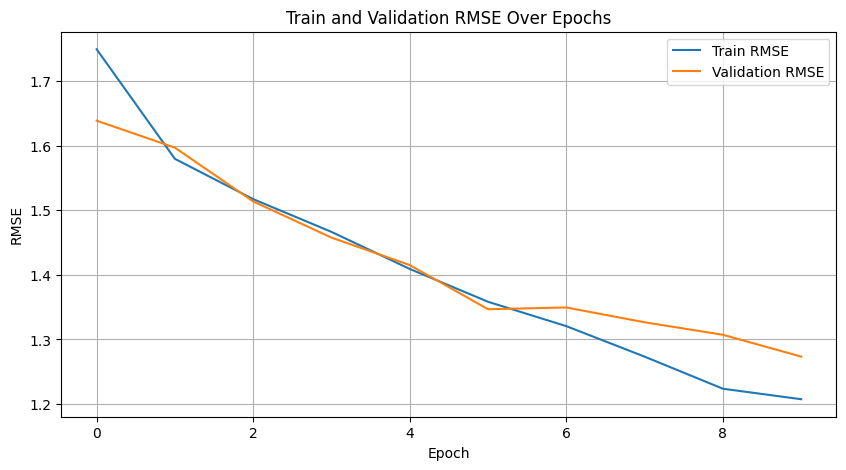

In [ ]:
import numpy as np

train_rmse_scores = [np.sqrt(loss) for loss in train_losses]
val_rmse_scores = [np.sqrt(mse) for mse in val_mse_scores]

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_scores, label='Train RMSE')
plt.plot(val_rmse_scores, label='Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save performance data

# assemble into a DataFrame
df_fusion__model_performance_10_epochs_MSE = pd.DataFrame({
    'epoch': np.arange(1, len(train_rmse_scores) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_rmse': train_rmse_scores,
    'val_rmse': val_rmse_scores,
    'val_mse': val_mse_scores,
})

# save as CSV
df_fusion__model_performance_10_epochs_MSE.to_csv('Fusion_model_10_epochs_MSE', index=False)

100%|██████████| 515/515 [00:23<00:00, 21.56it/s]


✅ Pearson r = 0.738 (p=0.0e+00)
✅ Spearman ρ = 0.713
✅ R² = 0.541


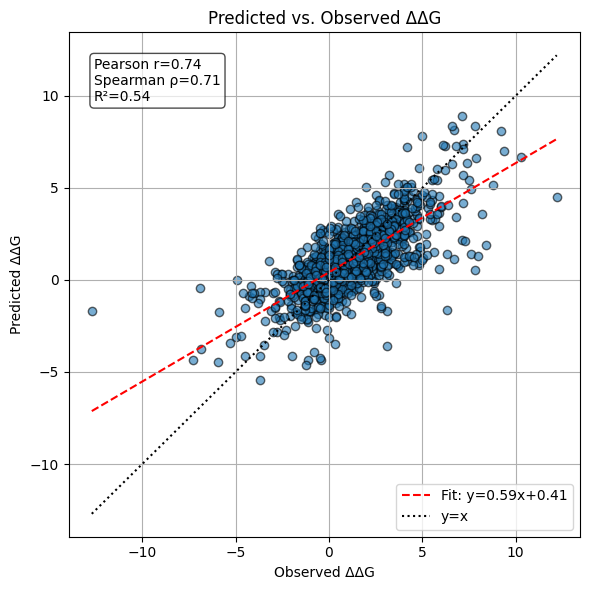

In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

model.eval()
preds, targets = [], []

with torch.no_grad():
    for data_wt, data_mut, ddg, metadata in tqdm(val_loader_official):
        wt_seqs = metadata['sequence']
        positions = metadata['position']
        mt_seqs = [''] * len(wt_seqs)

        for i in range(len(wt_seqs)):
            pos = min(positions[i] - 1, len(wt_seqs[i]) - 1)
            mt_seq = list(wt_seqs[i])
            mt_seq[pos] = metadata['mutation'][i]
            mt_seqs[i] = ''.join(mt_seq)

        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = model(wt_seqs, mt_seqs, data_wt, data_mut)

        preds.extend(pred.view(-1).cpu().numpy())
        targets.extend(ddg.view(-1).cpu().numpy())

# Convert to numpy arrays
preds = np.array(preds)
targets = np.array(targets)

# Metrics
pearson_r, pearson_p = pearsonr(targets, preds)
spearman_rho, _ = spearmanr(targets, preds)
r2 = r2_score(targets, preds)

print(f"✅ Pearson r = {pearson_r:.3f} (p={pearson_p:.1e})")
print(f"✅ Spearman ρ = {spearman_rho:.3f}")
print(f"✅ R² = {r2:.3f}")

# Plot predicted vs. true
m, b = np.polyfit(targets, preds, 1)
x_line = np.linspace(targets.min(), targets.max(), 100)

plt.figure(figsize=(6, 6))
plt.scatter(targets, preds, alpha=0.6, edgecolor='k')
plt.plot(x_line, m * x_line + b, 'r--', label=f'Fit: y={m:.2f}x+{b:.2f}')
plt.plot(x_line, x_line, 'k:', label='y=x')

plt.xlabel("Observed ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("Predicted vs. Observed ΔΔG")
plt.legend(loc="best")
plt.text(0.05, 0.95,
         f"Pearson r={pearson_r:.2f}\nSpearman ρ={spearman_rho:.2f}\nR²={r2:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.grid(True)
plt.tight_layout()
plt.show()


# Validating the Loaded PKL's and Wrapper for Old DeltaDDGDataset Class

In [ ]:
train_dataset.meta[0]

{'experiment_id': 'VB05069',
 'protein_name': 'Thermonuclease',
 'uniprot_id': 'P00644',
 'pdb_id': '1STN|1EY0',
 'chain': 'A',
 'position': 164,
 'wild_type': 'T',
 'mutation': 'S',
 'ddG': 0.6,
 'sequence': 'MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSCLVLTLVVVSSLSSSANASQTDNGVNRSGSEDPTVYSATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEKLNIWSEDNADSGQ',
 'is_in_catalytic_pocket': True,
 'is_essential': False}

In [ ]:
temp = train_dataset.meta[0]
temp.pop("sequence_mt")

'hello'

In [ ]:
train_dataset.meta[0]

{'experiment_id': 'VB05069',
 'protein_name': 'Thermonuclease',
 'uniprot_id': 'P00644',
 'pdb_id': '1STN|1EY0',
 'chain': 'A',
 'position': 164,
 'wild_type': 'T',
 'mutation': 'S',
 'ddG': 0.6,
 'sequence': 'MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSCLVLTLVVVSSLSSSANASQTDNGVNRSGSEDPTVYSATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEKLNIWSEDNADSGQ',
 'is_in_catalytic_pocket': True,
 'is_essential': False}

In [ ]:
"hel# Update sequence_mutant column
for index, row in df.iterrows():
  s = list(row["sequence_mutant"])
  s[row["position"]-1] = row["mutation"]
  s = "".join(s)
  df.at[index,"sequence_mutant"] = s

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [ ]:
next(iter(train_loader))

[DataBatch(x=[632, 23], edge_index=[2, 5548], edge_attr=[5548, 1], y=[4], batch=[632], ptr=[5]),
 DataBatch(x=[488, 23], edge_index=[2, 4610], edge_attr=[4610, 1], y=[4], batch=[488], ptr=[5]),
 tensor([-0.5000,  2.0000,  2.3000,  0.4000])]

In [ ]:
train_dataset.meta

In [ ]:
##### wrapper to include metadata and saving

import pickle
import torch

class DatasetWithMetadata(torch.utils.data.Dataset):
    def __init__(self, base_dataset, metadata):
        self.base_dataset = base_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata) # return self.base_dataset.__len__()

    def __getitem__(self, idx):
        # data_wt, data_mut, ddg = self.base_dataset[idx]
        data_wt, data_mut, ddg = self.base_dataset.__getitem__(idx)
        meta = self.metadata[idx]
        return data_wt, data_mut, ddg, meta

    def save(self, filepath):
        """Save the dataset wrapper and all needed components."""
        to_save = {
            'pairs': self.base_dataset.pairs,
            'metadata': self.metadata
        }
        with open(filepath, 'wb') as f:
            pickle.dump(to_save, f)
        print(f"✅ Dataset saved to {filepath}")

    @classmethod
    def load(cls, filepath):
            """Load the dataset and return a DatasetWithMetadata object."""
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)

            class BasePairsDataset(torch.utils.data.Dataset):
                def __init__(self, pairs):
                    self.pairs = pairs

                def __len__(self):
                    return len(self.pairs)

                def __getitem__(self, idx):
                    return self.pairs[idx]

            base_dataset = BasePairsDataset(obj['pairs'])
            return cls(base_dataset=base_dataset, metadata=obj['metadata'])



In [ ]:
train_dataset_wrapped = DatasetWithMetadata(train_dataset, train_dataset.meta)
val_dataset_wrapped = DatasetWithMetadata(val_dataset, val_dataset.meta)


In [ ]:
train_loader = DataLoader(train_dataset_wrapped, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset_wrapped, batch_size=4)

# next(iter(train_loader))

NameError: name 'train_dataset_wrapped' is not defined

In [ ]:
next(iter(train_loader))

[DataBatch(x=[1013, 23], edge_index=[2, 8688], edge_attr=[8688, 1], y=[4], batch=[1013], ptr=[5]),
 DataBatch(x=[741, 23], edge_index=[2, 7306], edge_attr=[7306, 1], y=[4], batch=[741], ptr=[5]),
 tensor([-0.4800,  3.0000,  3.5000,  2.6000]),
 {'experiment_id': ['PT021091', 'LL002149', 'VB01894', 'VB05344'],
  'protein_name': ['Cold shock protein CspB',
   'Cellular tumor antigen p53',
   'Ribonuclease',
   'Maltose/maltodextrin-binding periplasmic protein'],
  'uniprot_id': ['P32081', 'P04637', 'P00648', 'P0AEX9'],
  'pdb_id': ['1CSP',
   '1TUP|1TUP|1TUP|1TUP|1TUP|1SAK|1SAK|1SAK|1SAK|2OCJ',
   '1BNI|1A2P',
   '3MBP|1SVX|1SVX'],
  'chain': ['A', 'A', 'A', 'A'],
  'position': tensor([ 55, 282,  60, 115]),
  'wild_type': ['N', 'R', 'Y', 'L'],
  'mutation': ['D', 'W', 'A', 'A'],
  'ddG': tensor([-0.4800,  3.0000,  3.5000,  2.6000]),
  'sequence': ['MLEGKVKWFNSEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQAVSFEIVEGNRGPQAANVTKEA',
   'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPE

In [ ]:
train_dataset_wrapped.save("train_dataset_with_metadata.pkl")
val_dataset_wrapped.save("val_dataset_with_metadata.pkl")


✅ Dataset saved to train_dataset_with_metadata.pkl
✅ Dataset saved to val_dataset_with_metadata.pkl


In [ ]:
train_dataset_wrapped_ahhhh = DatasetWithMetadata.load("train_dataset_with_metadata.pkl")
val_dataset_wrapped_ahhhh = DatasetWithMetadata.load("val_dataset_with_metadata.pkl")


NameError: name 'DatasetWithMetadata' is not defined

In [ ]:
!ls -lh


total 8.0K
drwx------ 6 root root 4.0K May  4 16:29 drive
drwxr-xr-x 1 root root 4.0K Apr 30 13:37 sample_data


In [ ]:
train_dataset_wrapped_loader = DataLoader(train_dataset_wrapped_ahhhh, batch_size=4, shuffle=True)
val_dataset_wrapped_loader = DataLoader(val_dataset_wrapped_ahhhh, batch_size=4)

In [ ]:
next(iter(train_dataset_wrapped_loader))

[DataBatch(x=[2725, 23], edge_index=[2, 26222], edge_attr=[26222, 1], y=[4], batch=[2725], ptr=[5]),
 DataBatch(x=[599, 23], edge_index=[2, 5748], edge_attr=[5748, 1], y=[4], batch=[599], ptr=[5]),
 tensor([-0.6000, -6.2000,  2.8000,  2.4000]),
 {'experiment_id': ['VB00708', 'VB03666', 'PT019624', 'VB02977'],
  'protein_name': ['Ribonuclease HI',
   'Tryptophan synthase alpha chain',
   '30S ribosomal protein S6',
   'Tenascin'],
  'uniprot_id': ['P0A7Y4', 'P0A877', 'P23370', 'P24821'],
  'pdb_id': ['2RN2', '1WQ5', '1RIS|1RIS|1RIS|1RIS', '1TEN'],
  'chain': ['A', 'A', 'A', 'A'],
  'position': tensor([ 23,  49,  26, 849]),
  'wild_type': ['G', 'E', 'I', 'I'],
  'mutation': ['A', 'L', 'A', 'A'],
  'ddG': tensor([-0.6000, -6.2000,  2.8000,  2.4000]),
  'sequence': ['MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNRMELMAAIVALEALKEHCEVILSTDSQYVRQGITQWIHNWKKRGWKTADKKPVKNVDLWQRLDAALGQHQIKWEWVKGHAGHPENERCDELARAAAMNPTLEDTGYQVEV',
   'MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGADALELGIPFSDPLADGPTI

In [ ]:
train_dataset.__getitem__(0)

(Data(x=[231, 23], edge_index=[2, 2004], edge_attr=[2004, 1], y=[1], batch=[231]),
 Data(x=[136, 23], edge_index=[2, 1334], edge_attr=[1334, 1], y=[1], batch=[136]),
 tensor(0.6000))